In [2]:
import os
os.chdir(os.path.expanduser("/network/group/aopp/predict/HMC009_UKKONEN_CLIMSIM/ClimSim"))
from climsim_utils.data_utils import *
from torchinfo import summary


In [3]:
grid_path = '../grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '../preprocessing/normalizations/'
grid_path = 'grid_info/ClimSim_low-res_grid-info.nc'
norm_path = 'preprocessing/normalizations/'


grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean_v4_pervar.nc').astype(np.float32)
input_max = xr.open_dataset(norm_path + 'inputs/input_max_v4_pervar.nc').astype(np.float32)
input_min = xr.open_dataset(norm_path + 'inputs/input_min_v4_pervar.nc').astype(np.float32)
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc').astype(np.float32)

ml_backend = 'pytorch'
input_abbrev = 'mlexpand'
output_abbrev = 'mlo'
data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale,
                  ml_backend = ml_backend,
                  normalize = True,
                  input_abbrev = input_abbrev,
                  output_abbrev = output_abbrev,
                  save_h5=True,
                  save_npy=False,
                  )



# set data path
data.data_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train/'
data.data_path = "/network/group/aopp/predict/HMC009_UKKONEN_CLIMSIM/ClimSim_data/ClimSim_low-res-expanded/train/"

data_save_path =  "/network/group/aopp/predict/HMC009_UKKONEN_CLIMSIM/ClimSim_data/ClimSim_low-res-expanded/train/preprocessed/"
# set inputs and outputs to V1 subset
#data.set_to_v1_vars()
#data.set_to_v2_vars()
#data.set_to_v4_vars()
data.set_to_v4_rnn_vars()

In [59]:
data_dir = "/network/group/aopp/predict/HMC009_UKKONEN_CLIMSIM/ClimSim_data/ClimSim_low-res-expanded/train/preprocessed/"
tr_data_fname = "data_v4_rnn_year2.h5"
tr_data_path = data_dir + tr_data_fname

tr_data_fname = ["data_v4_rnn_year2.h5", 
                "data_v4_rnn_year3.h5"]
tr_data_path = [data_dir + b for b in tr_data_fname]

use_val = False 
#use_val = True

if use_val:
    val_data_fname = "data_v4_rnn_year5.h5"
    val_data_path = data_dir + val_data_fname



In [9]:

vars_1D_outp = []; vars_2D_outp = []

all_vars = list(data.output_scale.keys())
for var in all_vars:
    if 'lev' in data.output_scale[var].dims:
        vars_2D_outp.append(var)
    else:
        vars_1D_outp.append(var)  
        
yscale_lev = data.output_scale[vars_2D_outp].to_dataarray(dim='features', name='outputs_lev').transpose().values
yscale_sca = data.output_scale[vars_1D_outp].to_dataarray(dim='features', name='outputs_sca').transpose().values

print(yscale_lev.shape, yscale_sca.shape)

(60, 6) (8,)


In [61]:
# inspect data
testfile = tr_data_path[0] if type(tr_data_path)==list else tr_data_path
hf = h5py.File(testfile, 'r')
print(hf.keys())
# <KeysViewHDF5 ['input_lev', 'input_sca', 'output_lev', 'output_sca']>
#print(hf.attrs.keys())
print(hf['input_lev'].attrs.keys())
ns, nlev, nx = hf['input_lev'].shape
print("ns", ns, "nlev", nlev,  "nx", nx)
print(hf['input_lev'].attrs.get('varnames'))
# future training data should have a "varnames" attribute for each dataset type 

#2D Input variables: ['state_t', 'state_q0001', 'state_q0002', 'state_q0003', 'state_u', 'state_v', 
# 'pbuf_ozone', 'pbuf_CH4', 'pbuf_N2O']
# NEW::
#['state_t' 'state_rh' 'state_q0002' 'state_q0003' 'state_u' 'state_v'
# 'state_t_dyn' 'state_q0_dyn' 'state_u_dyn' 'tm_state_t_dyn'
# 'tm_state_q0_dyn' 'tm_state_u_dyn' 'pbuf_ozone' 'pbuf_CH4' 'pbuf_N2O']
# We need pressure!

#1D (scalar) Input variables: ['state_ps', 'pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX', 'pbuf_TAUX', 
# 'pbuf_TAUY', 'pbuf_COSZRS', 'cam_in_ALDIF', 'cam_in_ALDIR', 'cam_in_ASDIF', 'cam_in_ASDIR', 
# 'cam_in_LWUP', 'cam_in_ICEFRAC', 'cam_in_LANDFRAC', 'cam_in_OCNFRAC', 'cam_in_SNOWHICE', 
# 'cam_in_SNOWHLAND', 'lat', 'lon']
ns, nx_sfc = hf['input_sca'].shape
print("nx_sfc:", nx_sfc)
print(hf['input_sca'].attrs.get('varnames'))

#2D Output variables: ['ptend_t', 'ptend_q0001', 'ptend_q0002', 'ptend_q0003', 'ptend_u', 'ptend_v']
ns, nlev, ny = hf['output_lev'].shape
print("ny:", ny)
print(hf['output_lev'].attrs.get('varnames'))


#1D (scalar) Output variables: ['cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 
#'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']
(ns, ny_sfc) = hf['output_sca'].shape
print("ny_sfc:", ny_sfc)
print(hf['output_sca'].attrs.get('varnames'))

hf.close()


#state_q0001 lev, ncol kg/kg Specific humidity
#state_q0002 lev, ncol kg/kg Cloud liquid mixing ratio
#state_q0003 lev, ncol kg/kg Cloud ice mixing ratio

<KeysViewHDF5 ['input_lev', 'input_sca', 'output_lev', 'output_sca']>
<KeysViewHDF5 ['varnames']>
ns 10091136 nlev 60 nx 15
['state_t' 'state_rh' 'state_q0002' 'state_q0003' 'state_u' 'state_v'
 'state_t_dyn' 'state_q0_dyn' 'state_u_dyn' 'tm_state_t_dyn'
 'tm_state_q0_dyn' 'tm_state_u_dyn' 'pbuf_ozone' 'pbuf_CH4' 'pbuf_N2O']
nx_sfc: 24
['state_ps' 'pbuf_SOLIN' 'pbuf_LHFLX' 'pbuf_SHFLX' 'pbuf_TAUX' 'pbuf_TAUY'
 'pbuf_COSZRS' 'cam_in_ALDIF' 'cam_in_ALDIR' 'cam_in_ASDIF' 'cam_in_ASDIR'
 'cam_in_LWUP' 'cam_in_ICEFRAC' 'cam_in_LANDFRAC' 'cam_in_OCNFRAC'
 'cam_in_SNOWHICE' 'cam_in_SNOWHLAND' 'tm_state_ps' 'tm_pbuf_SOLIN'
 'tm_pbuf_LHFLX' 'tm_pbuf_SHFLX' 'tm_pbuf_COSZRS' 'clat' 'slat']
ny: 6
['ptend_t' 'ptend_q0001' 'ptend_q0002' 'ptend_q0003' 'ptend_u' 'ptend_v']
ny_sfc: 8
['cam_out_NETSW' 'cam_out_FLWDS' 'cam_out_PRECSC' 'cam_out_PRECC'
 'cam_out_SOLS' 'cam_out_SOLL' 'cam_out_SOLSD' 'cam_out_SOLLD']


In [62]:
import os 
import gc
import sys
import torch
import torch.nn as nn
import torch.nn.parameter as Parameter

class MyRNN(nn.Module):
    def __init__(self, RNN_type='LSTM', 
                 nx = 9, nx_sfc=17, 
                 ny = 8, ny_sfc=8, 
                 nneur=(64,64), 
                 outputs_one_longer=False, # if True, inputs are a sequence
                 # of N and outputs a sequence of N+1 (e.g. predicting fluxes)
                 concat=False, out_scale=None, out_sfc_scale = None):
        # Simple bidirectional RNN (Either LSTM or GRU) for predicting column 
        # outputs shaped either (B, L, Ny) or (B, L+1, Ny) from column inputs
        # (B, L, Nx) and optionally surface inputs (B, Nx_sfc) 
        # If surface inputs exist, they are used to initialize first (upward) RNN 
        # Assumes top-of-atmosphere is first in memory i.e. at index 0 
        # if it's not the flip operations need to be moved!
        super(MyRNN, self).__init__()
        self.nx = nx
        self.ny = ny 
        self.nx_sfc = nx_sfc 
        self.ny_sfc = ny_sfc
        self.nneur = nneur 
        self.outputs_one_longer=outputs_one_longer
        if len(nneur) < 1 or len(nneur) > 3:
            sys.exit("Number of RNN layers and length of nneur should be 2 or 3")

        self.RNN_type=RNN_type
        if self.RNN_type=='LSTM':
            RNN_model = nn.LSTM
        elif self.RNN_type=='GRU':
            RNN_model = nn.GRU
        else:
            raise NotImplementedError()
                    
        self.concat=concat
        
        if out_scale is not None:
            cuda = torch.cuda.is_available() 
            device = torch.device("cuda" if cuda else "cpu")
            self.yscale_lev = torch.from_numpy(out_scale).to(device)
            self.yscale_sca = torch.from_numpy(out_sfc_scale).to(device)

        if self.nx_sfc > 0:
            self.mlp_surface1  = nn.Linear(nx_sfc, self.nneur[0])
            if self.RNN_type=="LSTM":
                self.mlp_surface2  = nn.Linear(nx_sfc, self.nneur[0])

        self.rnn1      = RNN_model(nx,            self.nneur[0], batch_first=True) # (input_size, hidden_size, num_layers=1
        self.rnn2      = RNN_model(self.nneur[0], self.nneur[1], batch_first=True)
        if len(self.nneur)==3:
            self.rnn3      = RNN_model(self.nneur[1], self.nneur[2], batch_first=True)

        # The final hidden variable is either the output from the last RNN, or
        # the  concatenated outputs from all RNNs
        if concat:
            nh_rnn = sum(nneur)
        else:
            nh_rnn = nneur[-1]

        self.mlp_output = nn.Linear(nh_rnn, self.ny)
        if self.ny_sfc>0:
            self.mlp_surface_output = nn.Linear(nneur[-1], self.ny_sfc)
            
    def postprocessing(self, out, out_sfc):
        out_denorm = out / self.yscale_lev
        out_sfc_denorm  = out_sfc / self.yscale_sca
        return out_denorm, out_sfc_denorm
    
    def forward(self, inputs_main, inputs_sfc):
            
        # batch_size = inputs_main.shape[0]
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      
        sfc1 = self.mlp_surface1(inputs_sfc)
        sfc1 = nn.Tanh()(sfc1)

        if self.RNN_type=="LSTM":
            sfc2 = self.mlp_surface2(inputs_sfc)
            sfc2 = nn.Tanh()(sfc2)
            hidden = (sfc1.view(1,-1,self.nneur[0]), sfc2.view(1,-1,self.nneur[0])) # (h0, c0)
        else:
            hidden = (sfc1.view(1,-1,self.nneur[0]))

        # print(f'Using state1 {hidden}')
        # TOA is first in memory, so we need to flip the axis
        inputs_main = torch.flip(inputs_main, [1])
      
        out, hidden = self.rnn1(inputs_main, hidden)
        
        if self.outputs_one_longer:
            out = torch.cat((sfc1, out),axis=1)

        out = torch.flip(out, [1]) # the surface was processed first, but for
        # the second RNN (and the final output) we want TOA first
        
        out2, hidden2 = self.rnn2(out) 
        
        (last_h, last_c) = hidden2

        if len(self.nneur)==3:
            rnn3_input = torch.flip(out2, [1])
            
            out3, hidden3 = self.rnn3(rnn3_input) 
            
            out3 = torch.flip(out3, [1])
            
            if self.concat:
                rnnout = torch.cat((out3, out2, out),axis=2)
            else:
                rnnout = out3
        else:
            if self.concat:
                rnnout = torch.cat((out2, out),axis=2)
            else:
                rnnout = out2
        
        out = self.mlp_output(rnnout)

        if self.ny_sfc>0:
            #print("shape last_c", last_c.shape)
            # use cell state or hidden state?
            out_sfc = self.mlp_surface_output(last_h.squeeze())
            return out, out_sfc
        else:
            return out 
        
        
 

    

In [63]:

class RNN_autoreg(nn.Module):
    def __init__(self, nlay=60, nx = 4, nx_sfc=3, ny = 4, ny_sfc=3, nneur=(64,64), 
                cell_type="LSTM",
                memory="None", # "None", "Hidden", or "Output",
                concat=False,
                use_initial_mlp=False, ensemble_size=1,
                random_init_cx=False,
                use_intermediate_mlp=True,
                add_pres=False,
                third_rnn=False,
                add_stochastic_layer=False,
                coeff_stochastic = 0.0,
                dtype=torch.float32,
                out_scale=None, out_sfc_scale=None):
        super(RNN_autoreg, self).__init__()
        self.nx = nx
        self.ny = ny 
        self.nlay = nlay 
        self.nx_sfc = nx_sfc 
        self.ny_sfc = ny_sfc
        self.nneur = nneur 
        self.use_initial_mlp=use_initial_mlp
        self.add_pres = add_pres
        if self.add_pres:
            self.preslay = LayerPressure()
            nx = nx +1
        self.nh_rnn1 = self.nneur[0]
        self.nx_rnn2 = self.nneur[0]
        self.nh_rnn2 = self.nneur[1]
        self.concat = concat
        self.model_type=cell_type
        self.ensemble_size = ensemble_size
        self.random_init_cx= random_init_cx
        self.third_rnn=third_rnn
        self.add_stochastic_layer = add_stochastic_layer
        self.coeff_stochastic = coeff_stochastic
        self.dtype=dtype
        if self.ensemble_size>1 and not add_stochastic_layer:
        # In this case the stochasticity comes purely from random initialization
        # of hidden states (probably not enough)
            self.random_init_cx=True
        self.use_intermediate_mlp=use_intermediate_mlp
        self.share_weights = False
        if self.share_weights:
            self.use_intermediate_mlp=False
        if self.use_initial_mlp:
            self.nx_rnn1 = self.nneur[0]
        else:
            self.share_weights=False
            self.nx_rnn1 = nx
        self.memory = memory
        if out_scale is not None:
            cuda = torch.cuda.is_available() 
            device = torch.device("cuda" if cuda else "cpu")
            self.yscale_lev = torch.from_numpy(out_scale).to(device)
            self.yscale_sca = torch.from_numpy(out_sfc_scale).to(device)
        if memory == 'None':
            raise NotImplementedError()
        elif memory == 'Output':
            print("Building RNN that feeds its output t0,z0 to its inputs at t1,z0")
            self.rnn1_mem = None 
            self.nh_mem = self.ny
            self.nx_rnn1 = self.nx_rnn1 + self.nh_mem
            self.nh_rnn1 = self.nneur[0]
        elif memory == 'Hidden':
            self.nh_mem = self.nneur[1]
            print("Building RNN that feeds its hidden memory at t0,z0 to its inputs at t1,z0")
            print("Initial mlp: {}, intermediate mlp: {}".format(self.use_initial_mlp, self.use_intermediate_mlp))
 
            self.rnn1_mem = None 
            self.nx_rnn1 = self.nx_rnn1 + self.nh_mem
            self.nh_rnn1 = self.nneur[0]
        elif memory == 'CustomLSTM':
            raise NotImplementedError()
        else:
            sys.exit("memory argument must equal one of : 'None', 'Hidden', or 'CustomLSTM'")
            
        print("nx rnn1", self.nx_rnn1, "nh rnn1", self.nh_rnn1)
        print("nx rnn2", self.nx_rnn2, "nh rnn2", self.nh_rnn2)  
        print("Cell type:", cell_type)
        if self.use_initial_mlp:
            self.mlp_initial = nn.Linear(nx, self.nneur[0])

        self.mlp_surface1  = nn.Linear(nx_sfc, self.nh_rnn1)
        if not self.random_init_cx:
            self.mlp_surface2  = nn.Linear(nx_sfc, self.nh_rnn1)

        if self.model_type=="LSTM":
            # self.rnn1      = nn.LSTMCell(self.nx_rnn1, self.nh_rnn1)  # (input_size, hidden_size)
            # self.rnn2      = nn.LSTMCell(self.nx_rnn2, self.nh_rnn2)
            self.rnn1      = nn.LSTM(self.nx_rnn1, self.nh_rnn1,  batch_first=True)  # (input_size, hidden_size)
            if not self.share_weights:
                self.rnn2      = nn.LSTM(self.nx_rnn2, self.nh_rnn2,  batch_first=True)
                if self.third_rnn:
                    self.rnn3      = nn.LSTM(self.nh_rnn2, self.nneur[2],  batch_first=True)
                
        elif self.model_type=="GRU":
              self.rnn1      = nn.GRU(self.nx_rnn1, self.nh_rnn1,  batch_first=True)   # (input_size, hidden_size)
              self.rnn2      = nn.GRU(self.nx_rnn2, self.nh_rnn2,  batch_first=True) 
        elif self.model_type=="RNN":
              self.rnn1      = nn.RNN(self.nx_rnn1, self.nh_rnn1,  batch_first=True)   # (input_size, hidden_size)
              self.rnn2      = nn.RNN(self.nx_rnn2, self.nh_rnn2,  batch_first=True) 
        else:
            raise NotImplementedError()
            
        if self.add_stochastic_layer:
            from models_torch_kernels import StochasticGRUCell, MyStochasticGRUCell
            nx_srnn = self.nh_rnn2
            # self.rnn_stochastic = StochasticGRUCell(nx_srnn, self.nh_rnn2)  # (input_size, hidden_size)
            self.rnn_stochastic = MyStochasticGRUCell(nx_srnn, self.nh_rnn2)  # (input_size, hidden_size)
        if concat:
            nh_rnn = self.nh_rnn2+self.nh_rnn1
        else:
            nh_rnn = self.nh_rnn2

        if self.use_intermediate_mlp: 
            self.mlp_latent = nn.Linear(nh_rnn, self.nh_rnn1)
            self.mlp_output = nn.Linear(self.nh_rnn1, self.ny)
        else:
            self.mlp_output = nn.Linear(nh_rnn, self.ny)
            
        if self.ny_sfc>0:
            self.mlp_surface_output = nn.Linear(nneur[-1], self.ny_sfc)
            
    def postprocessing(self, out, out_sfc):
        out_denorm = out / self.yscale_lev
        out_sfc_denorm  = out_sfc / self.yscale_sca
        return out_denorm, out_sfc_denorm
    
    def reset_states(self):
        self.rnn1_mem = None

    def detach_states(self):
        self.rnn1_mem = self.rnn1_mem.detach()
   
    def get_states(self):
        return self.rnn1_mem.detach()

    def set_states(self, states):
        self.rnn1_mem = states 
        
    def forward(self, inputs_main, inputs_sfc):
        if self.ensemble_size>0:
            inputs_main = inputs_main.unsqueeze(0)
            inputs_sfc = inputs_sfc.unsqueeze(0)
            inputs_main = torch.repeat_interleave(inputs_main,repeats=self.ensemble_size,dim=0)
            inputs_sfc = torch.repeat_interleave(inputs_sfc,repeats=self.ensemble_size,dim=0)
            inputs_main = inputs_main.flatten(0,1)
            inputs_sfc = inputs_sfc.flatten(0,1)
                    
        batch_size = inputs_main.shape[0]
        if self.add_pres:
            sp = inputs_sfc[:,-1]
            pres  = self.preslay(sp)
            inputs_main = torch.cat((inputs_main,torch.unsqueeze(pres,2)),dim=2)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     
        if self.rnn1_mem is None: 
            # self.rnn1_mem = torch.randn(batch_size, self.nlay, self.nh_mem,device=device)
            self.rnn1_mem = torch.randn((batch_size, self.nlay, self.nh_mem),dtype=self.dtype,device=device)

        hx = self.mlp_surface1(inputs_sfc)
        hx = nn.Tanh()(hx)

        # TOA is first in memory, so to start at the surface we need to go backwards
        inputs_main = torch.flip(inputs_main, [1])

        # The input (a vertical sequence) is concatenated with the
        # output of the RNN from the previous time step 
        if self.model_type in ["LSTM"]:
            if self.random_init_cx:
                # cx = torch.randn(batch_size, self.nh_rnn1,device=device)
                cx = torch.randn((batch_size, self.nh_rnn1),dtype=self.dtype,device=device)
            else:
                cx = self.mlp_surface2(inputs_sfc)
                cx = nn.Tanh()(cx)
            hidden = (torch.unsqueeze(hx,0), torch.unsqueeze(cx,0))
        else:
            hidden = (torch.unsqueeze(hx,0))

        if self.use_initial_mlp:
            rnn1_input = self.mlp_initial(inputs_main)
            rnn1_input = nn.Tanh()(rnn1_input)
        else:
            rnn1_input = inputs_main 
            
        rnn1_input = torch.cat((rnn1_input,self.rnn1_mem), axis=2)

        rnn1out, states = self.rnn1(rnn1_input, hidden)

        rnn1out = torch.flip(rnn1out, [1])

        hx2 = torch.randn((batch_size, self.nh_rnn2),dtype=self.dtype,device=device)  # (batch, hidden_size)
        if self.model_type in ["LSTM"]:
            cx2 = torch.randn((batch_size, self.nh_rnn2),dtype=self.dtype,device=device)
            hidden2 = (torch.unsqueeze(hx2,0), torch.unsqueeze(cx2,0))
        else:
            hidden2 = (torch.unsqueeze(hx2,0))

        input_rnn2 = rnn1out
            
        if self.share_weights:
            rnn2out, states = self.rnn1(input_rnn2, hidden2)
        else:
            rnn2out, states = self.rnn2(input_rnn2, hidden2)

        (last_h, last_c) = states

        if self.third_rnn:
            rnn3in = torch.flip(rnn2out, [1])
            rnn2out, states = self.rnn3(rnn3in)

        if self.concat:
            rnn2out = torch.cat((rnn2out,rnn1out),axis=2)
        
        if self.use_intermediate_mlp: 
            rnn2out = self.mlp_latent(rnn2out)
          
        if self.memory=="Hidden": 
            if not self.third_rnn: self.rnn1_mem = torch.flip(rnn2out, [1])
            
        # Add a stochastic perturbation
        # Convective memory is still based on the deterministic model,
        # and does not include the stochastic perturbation
        # concat and use_intermediate_mlp should be set to false
        if self.add_stochastic_layer:
            # srnn_input = torch.transpose(rnn2out,0,1)
            srnn_input = torch.transpose(self.rnn1_mem,0,1)
            # transpose is needed because this layer assumes seq. dim first
            z = self.rnn_stochastic(srnn_input)
            z = torch.flip(z, [0])

            z = torch.transpose(z,0,1)
            # z = torch.flip(z, [1])
            # rnn2out = z
            # z is a perburbation added to the hidden state
            # rnn2out = rnn2out + 0.01*z 
            rnn2out = rnn2out + self.coeff_stochastic*z 

        out = self.mlp_output(rnn2out)
        if self.memory=="Output":
            if not self.third_rnn: self.rnn1_mem = torch.flip(out, [1])

        if self.ny_sfc>0:
            #print("shape last_c", last_c.shape)
            # use cell state or hidden state?
            out_sfc = self.mlp_surface_output(last_h.squeeze())
            return out, out_sfc
        else:
            return out 
        

class SpaceStateModel(nn.Module):
    def __init__(self, nlay=30, nx = 4, nx_sfc=3, ny = 4, nneur=(64,64),model_type='LRU', 
                 use_initial_mlp=True, add_pres=False,  concat=False,
                 third_rnn=False, init_with_state_and_sfc=False, memory=None,
                 dtype=torch.float32,
                 device=None):
        super(SpaceStateModel, self).__init__()
        self.nx = nx
        self.ny = ny 
        self.nlay = nlay 
        self.nx_sfc = nx_sfc 
        self.nneur = nneur 
        self.add_pres = add_pres
        if self.add_pres:
            self.preslay = LayerPressure()
            nx = nx +1
        self.nh_rnn1 = self.nneur[0]
        self.nh_rnn2 = self.nneur[1]
        self.ny_rnn1 = self.nh_rnn1
        self.use_initial_mlp=use_initial_mlp
        self.init_with_state_and_sfc = init_with_state_and_sfc
        self.model_type=model_type
        self.dtype=dtype
        self.device=device
        if self.device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using model type {}".format(model_type))
        if self.model_type in ["Mamba","GSS"]:#,"QRNN"]:  #Mamba doesnt support providing the state
            print("WARNING: this SSM type doesn't support providing the state, so the surface variables are instead added to each point in the sequence")
            
            # concatenate the vertical (sequence) inputs with tiled scalars
            self.init_with_state_and_sfc=False
            self.use_initial_mlp=True
            nx = nx + nx_sfc
        if self.use_initial_mlp: 
            self.nh_mlp1 = self.nh_rnn1
            self.nx_rnn1 = self.nh_rnn1
        else:
            self.nx_rnn1 = nx
        self.use_intermediate_mlp = False
        if memory == 'None':
            print("Building non-autoregressive SSM, but may be stateful")
            self.autoregressive = False
        elif memory == 'Hidden':
            print("Building autoregressive SSM that feeds a hidden memory at t0,z0 to SSM1 at t1,z0")
            self.autoregressive = True
            self.rnn1_mem = None
            # self.rnn2_mem = None
            # self.use_intermediate_mlp = True
            
        # if self.use_intermediate_mlp:
        #     self.nh_latent = self.nh_rnn2
        self.nh_latent = self.nh_rnn2
        glu_expand_factor = 2
        # if model_type in ['S5','GSS','QRNN','Mamba','GateLoop','SRU','LRU']:
        if model_type in ['S5','GSS','QRNN','Mamba','GateLoop','SRU','SRU_2D','LRU']:
            self.use_initial_mlp = True
            self.use_intermediate_mlp = True; self.nh_latent = self.nh_rnn2
            self.nx_rnn1 = self.nh_rnn1 
            self.nx_rnn2 = self.nh_rnn2
            if self.autoregressive and model_type != 'SRU_2D':
                # This is a bit tricky with these SSMs as they expect 
                # num_inputs = num_hidden. Therefore we need MLPs that halve 
                # the size of both inputs and the final hidden variable, e.g.
                # SSM = 128 neurons, Xlay = 64 neurons, Xhidden = 64 neurons,
                # X = concat(Xlay,Xhidden)
                # Similarly, to feed the latent variable to RNN2, we would need an MLP before it
                # that halves the size of  the output from RNN1
                #    mlp1      concat(mlp1,hfin=64)     RNN1(128)     MLP2     concat(mlp2,hfin=64)      RNN2(128)     mlpfin
                # nx ----> 64 ---------------------> 128 -------> 128 ---> 64 ---------------------> 128 --------> 128 ----->  64
                #   OR let second SSMs hidden size be bigger
                #    mlp1      concat(mlp1,hfin=64)     RNN1(128)      concat(hfin=64)           RNN2(192)     mlpfin
                # nx ----> 64 ---------------------> 128 -------> 128 ---------------------> 192 --------> 192 ----->  64  
                # or Dont bother making RNN2 autoregressive?
                # mlp1        concat(hfin=128)          RNN1(256)     GLU      RNN2(128)    GLU      RNN3
                # nx ---> 128 ---------------------> 256 -------> 256 ---> 128 -------> 128 ---> 128 --->  128

                self.nh_latent = self.nh_rnn1//2
                self.ny_rnn1 = self.nh_rnn1//2
                self.nh_mlp1  = self.nh_rnn1//2 
                self.nh_mlp2  = self.nh_rnn1
                # self.nh_rnn2 = self.nh_rnn1  + self.nh_latent
                # self.nx_rnn2 = self.nh_rnn2
                # self.nh_rnn2 = self.nh_rnn1 
                self.nx_rnn2 = self.nh_rnn2
                glu_expand_factor = 1
        else:
            self.nx_rnn2 = self.nh_rnn1
            if self.autoregressive:
                self.nx_rnn1 = self.nx_rnn1 + self.nh_latent 
                # self.nx_rnn2 = self.nh_rnn1 + self.nh_latent 

        if self.use_initial_mlp:
            self.mlp_initial = nn.Linear(nx, self.nh_mlp1 )
        self.third_rnn=third_rnn

        print("nx rnn1", self.nx_rnn1, "nh rnn1", self.nh_rnn1, "ny rnn1", self.ny_rnn1)
        print("nx rnn2", self.nx_rnn2, "nh rnn2", self.nh_rnn2)  
        if self.autoregressive: 
            print("nh_memory", self.nh_latent)
        self.concat = concat

        if self.init_with_state_and_sfc:
            self.state1 = None
            # self.state2 = None 
            self.mlp_surface1  = nn.Linear(nx_sfc + self.nh_rnn1, self.nh_rnn1)
        else:
            self.mlp_surface1  = nn.Linear(nx_sfc, self.nh_rnn1)

        if model_type == 'LRU':
            from models_torch_kernels_LRU import LRU
            self.rnn1= LRU(in_features=self.nx_rnn1,out_features=self.nh_rnn1,state_features=self.nh_rnn1)
            self.rnn2= LRU(in_features=self.nx_rnn2,out_features=self.nh_rnn2,state_features=self.nh_rnn2)
        elif model_type == "MinGRU":
            # MinGRU = models_torch_kernels.MinGRU
            from models_torch_kernels import MinGRU as MinGRU
            self.rnn1= MinGRU(self.nx_rnn1,self.nh_rnn1)
            self.rnn2= MinGRU(self.nx_rnn2,self.nh_rnn2)
            # from models_torch_kernels import minGRU as MinGRU
            # self.rnn1= MinGRU(self.nh_rnn1)
            # self.rnn2= MinGRU(self.nh_rnn2)
            if self.third_rnn:
                self.rnn3= MinGRU(self.nx_rnn2,self.nh_rnn2)
        elif model_type == 'S5':
            from s5 import S5
            self.liquid=False
            self.pres_step_scale = False
            # S5 outputs shape equals inputs?
            # self.rnn1= S5(self.nx_rnn1,self.nh_rnn1,liquid=self.liquid)
            # self.rnn2= S5(self.nx_rnn2,self.nh_rnn2,liquid=self.liquid)   
            # self.rnn1= S5(self.nh_rnn1,liquid=self.liquid)
            # self.rnn2= S5(self.nh_rnn2,liquid=self.liquid)   
            self.rnn1= S5(self.nx_rnn1,liquid=self.liquid)
            self.rnn2= S5(self.nx_rnn2,liquid=self.liquid)  
        elif model_type == 'Mamba':
            from mamba_ssm import Mamba
            self.rnn1 = Mamba(
                # This module uses roughly 3 * expand * d_model^2 parameters
                d_model=self.nx_rnn1, # Model dimension d_model
                d_state=16,  # SSM state expansion factor
                d_conv=4,    # Local convolution width
                expand=2,    # Block expansion factor
                )
            self.rnn2 = Mamba(
                # This module uses roughly 3 * expand * d_model^2 parameters
                d_model=self.nx_rnn2, # Model dimension d_model
                d_state=16,  # SSM state expansion factor
                d_conv=4,    # Local convolution width
                expand=2,    # Block expansion factor
                )
        elif model_type == 'GSS':
            from gated_state_spaces_pytorch import GSS
            self.rnn1= GSS(dim=self.nx_rnn1,dss_kernel_N=self.nh_rnn1,dss_kernel_H=self.nh_rnn1)
            self.rnn2= GSS(dim=self.nx_rnn2,dss_kernel_N=self.nh_rnn2,dss_kernel_H=self.nh_rnn2)
        elif model_type == 'QRNN':
            from models_torch_kernels import QRNNLayer, QRNNLayer_noncausal
            kernelsize = 3
            self.rnn1= QRNNLayer_noncausal(self.nx_rnn1,self.nh_rnn1, kernel_size=3, pad =(0,1))
            self.rnn2= QRNNLayer_noncausal(self.nx_rnn2,self.nh_rnn2, kernel_size=3) 
            
            if self.init_with_state_and_sfc:
                self.mlp_surface2  = nn.Linear(nx_sfc + self.nh_rnn1, self.nh_rnn1)
            else:
                self.mlp_surface2  = nn.Linear(nx_sfc, self.nh_rnn1)  
        elif model_type == 'SRU':
            from models_torch_kernels import SRU
            self.rnn1= SRU(self.nx_rnn1,self.nh_rnn1)
            self.rnn2= SRU(self.nx_rnn2,self.nh_rnn2)  
            # from sru import SRU
            # self.rnn1= SRU(self.nx_rnn1,self.nh_rnn1,num_layers=1)
            # self.rnn2= SRU(self.nx_rnn2,self.nh_rnn2,num_layers=1)
        elif model_type == "SRU_2D":
            from models_torch_kernels import SRU, SRU2
            self.rnn1= SRU2(self.nx_rnn1,self.nh_rnn1)
            self.rnn2= SRU(self.nx_rnn2,self.nh_rnn2)  
        elif model_type == 'GateLoop':
            from gateloop_transformer import SimpleGateLoopLayer
            self.rnn1= SimpleGateLoopLayer(self.nx_rnn1) #, use_jax_associative_scan=True)
            self.rnn2= SimpleGateLoopLayer(self.nx_rnn2) #, use_jax_associative_scan=True)
            if self.third_rnn:
                self.rnn3= SimpleGateLoopLayer(self.nneur[2])
                
            if self.init_with_state_and_sfc:
                self.mlp_surface2  = nn.Linear(nx_sfc + self.nh_rnn1, self.nh_rnn1)
            else:
                self.mlp_surface2  = nn.Linear(nx_sfc, self.nh_rnn1)
        else:
            
            raise NotImplementedError()

        # if model_type in ['LRU','S5','GSS','QRNN','Mamba']:
        # if model_type in ['LRU','SRU','S5','GSS','QRNN','GateLoop','MinGRU']:
        # if model_type in ['LRU','SRU','S5','GSS','QRNN','GateLoop','MinGRU','Mamba']:
        if model_type in ['LRU','SRU','SRU_2D','S5','QRNN','GateLoop','MinGRU',]:

            self.use_glu_layers = True 
        else:
            self.use_glu_layers = False
            
        self.reduce_dim_with_mlp=False
        if self.use_glu_layers:
            print("Using GLU layers in between for nonlinearity, expand factor (1 means halving output) for GLU1 is ", glu_expand_factor)
            glu_layernorm=True
            # glu_layernorm=False

            # self.rnn1= LRU(in_features=nx_rnn1,out_features=self.nneur[0],state_features=self.nneur[0])
            # self.mlp  = nn.Linear(self.nneur[0], self.nneur[0])
            # self.SeqLayer1 = SequenceLayer(nlay=self.nlay,nneur=self.nneur[0],layernorm=True)
            self.SeqLayer1 = GLU(nlay=self.nlay,nneur=self.nh_rnn1,layernorm=glu_layernorm, expand_factor=glu_expand_factor)
    
            # self.rnn2= LRU(in_features=nx_rnn2,out_features=self.nneur[1],state_features=self.nneur[0])
            # self.mlp2  = nn.Linear(self.nneur[1], self.nneur[1])
            # self.SeqLayer2 = SequenceLayer(nlay=self.nlay,nneur=self.nneur[1],layernorm=True)
            self.SeqLayer2 = GLU(nlay=self.nlay,nneur=self.nh_rnn2,layernorm=glu_layernorm)

            # self.SeqLayer15 = GLU(nlay=self.nlay,nneur=self.nneur[0],layernorm=glu_layernorm)
        else:
            if self.autoregressive and model_type in ['S5','GSS','QRNN','Mamba','GateLoop','SRU','SRU_2D''LRU']:
                   self.reduce_dim_with_mlp=True
                   self.reduce_dim_mlp = nn.Linear(self.nh_rnn1, self.nx_rnn2)
                   
        if self.third_rnn:
            # self.rnn3= LRU(in_features=nx_rnn2,out_features=self.nneur[1],state_features=self.nneur[0])
            # self.rnn3= LRU(in_features=self.nneur[1],out_features=self.nneur[1],state_features=self.nneur[1])
            # self.mlp3  = nn.Linear(self.nneur[1], self.nneur[1])
            # self.SeqLayer3 = SequenceLayer(nlay=self.nlay,nneur=self.nneur[1],layernorm=True)
            if self.use_glu_layers: self.SeqLayer3 = GLU(nlay=self.nlay,nneur=self.nneur[2],layernorm=glu_layernorm)

        if self.concat:
            nx_last = self.ny_rnn1 + self.nh_rnn2
            if self.third_rnn:  
                nx_last += self.nh_rnn2
        else:
            nx_last = self.nh_rnn2
            
        if self.use_intermediate_mlp:
            self.mlp_latent = nn.Linear(nx_last, self.nh_latent)
            nx_last = self.nh_latent

        self.mlp_output        = nn.Linear(nx_last, self.ny)

    def reset_states(self):
        if self.init_with_state_and_sfc:
            self.state1 = None
        if self.autoregressive:
            self.rnn1_mem = None
            # self.rnn2_mem = None

    def detach_states(self):
        if self.init_with_state_and_sfc:
            self.state1 = self.state1.detach()
        if self.autoregressive:
            self.rnn1_mem = self.rnn1_mem.detach()
            # self.rnn2_mem = self.rnn2_mem.detach()
        
    def forward(self, inputs_main, inputs_sfc):

        # print("Shape inputs main", inputs_main.shape)
        batch_size = inputs_main.shape[0]
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device=self.device
        if self.autoregressive:
            if self.rnn1_mem is None: 
                self.rnn1_mem = torch.randn((batch_size, self.nlay, self.nh_latent),dtype=self.dtype,device=device)
    
            # if self.rnn2_mem is None: 
            #     self.rnn2_mem = torch.randn(batch_size, self.nlay, self.nh_latent ,device=device)
        if self.add_pres:
            sp = inputs_sfc[:,-1]
            pres  = self.preslay(sp)
            inputs_main = torch.cat((inputs_main,torch.unsqueeze(pres,2)),dim=2)
        
        if self.model_type=="S5" and self.pres_step_scale:
                refp = inputs_main[:,:,-1].clone().detach()
        
        inputs_main = torch.flip(inputs_main, [1])
        
        if self.model_type=="S5" and self.pres_step_scale:
                refp_rev = inputs_main[:,:,-1].clone().detach()

        if self.model_type in ["Mamba","GSS"]:#,,"QRNN"]:
            #Mamba doesnt support providing the state, so as a hack we instead
            # concatenate the vertical (sequence) inputs with tiled scalars
            inputs_sfc_tiled = torch.tile(torch.unsqueeze(inputs_sfc,1),(1,self.nlay,1))
            inputs_main = torch.cat((inputs_main,inputs_sfc_tiled), dim=2)
        else:
            # Initial states can be a vector of shape (state_features,) or a matrix of shape (batch_size, state_features)
            if self.init_with_state_and_sfc:
                if self.state1==None:
                    self.state1 =  torch.randn((batch_size, self.nh_rnn1),dtype=self.dtype,device=device)
    
                init_inputs = torch.cat((inputs_sfc,self.state1), dim=1)
            else:
                init_inputs = inputs_sfc
                
            init_states = self.mlp_surface1(init_inputs)
            # init_states = nn.Softsign()(init_states)
            init_states = nn.Tanh()(init_states)
            # print("shape init states" , init_states.shape)
        # print("shape inp main inp", inputs_main.shape)

        if self.use_initial_mlp:
            rnn1_input = self.mlp_initial(inputs_main)
            rnn1_input = nn.Tanh()(rnn1_input)
        else:
            rnn1_input = inputs_main
        # print("shape rnn1 inp", rnn1_input.shape)

        if self.autoregressive and self.model_type != "SRU_2D":
            rnn1_input = torch.cat((rnn1_input,self.rnn1_mem), axis=2)

        # print("shape rnn1 inp", rnn1_input.shape)
            
        # B_tilde, C_tilde = self.rnn1.seq.get_BC_tilde()
        # print("shape B tild", B_tilde.shape, "C tild", C_tilde.shape)
        # shape B tild torch.Size([96, 96]) C tild torch.Size([96, 96])
        
        # if self.layernorm:
        #     rnn1_input = self.norm(rnn1_input)
        if self.model_type=="S5":
            if self.pres_step_scale:
                out = self.rnn1(rnn1_input,state=init_states, step_scale=refp_rev)
                # pres_rev = torch.flip(pres, [1])        
                # out = self.rnn1(rnn1_input,state=init_states, step_scale=pres_rev)
            else:
                out = self.rnn1(rnn1_input,state=init_states)
                # out,h = self.rnn1(rnn1_input,state=init_states,return_state=True)
                # print("OUT", out[0,-1,0], "STATE", h[0,0])
                # OUT tensor(-0.2206, device='cuda:0', grad_fn=<SelectBackward0>) STATE tensor(0.0096+0.0025j
        elif self.model_type in ["Mamba","GSS"]:#,"QRNN"]:
            out = self.rnn1(rnn1_input) 
        elif self.model_type == "QRNN":
            init_states2 = self.mlp_surface2(init_inputs)
            init_states2 = nn.Tanh()(init_states2)
            init_states = (init_states, init_states2)
            out = self.rnn1(rnn1_input,init_states) 

        elif self.model_type=="SRU":
            # print("init shape", init_states.shape)
            # init_states = init_states.view((1,batch_size,-1)) 
            out,c = self.rnn1(rnn1_input,init_states) 
        elif self.model_type=="SRU_2D":
            # print("init shape", init_states.shape)
            out,c = self.rnn1(rnn1_input,init_states, self.rnn1_mem) 
        elif self.model_type=="MinGRU":
            init_states = init_states.view((batch_size,1, -1)) 
            out = self.rnn1(rnn1_input,init_states)      
        elif self.model_type=="GateLoop":
            init_states2 = self.mlp_surface2(init_inputs)
            init_states2 = nn.Tanh()(init_states2)
            cache = [init_states.view(batch_size*self.nh_rnn1,1), init_states2.view(batch_size*self.nh_rnn1,1)]
            out = self.rnn1(rnn1_input,cache=cache)          
            # out = self.rnn1(rnn1_input)          

        else:
            # out = self.rnn1(rnn1_input,state=init_states) 
            out = self.rnn1(rnn1_input,init_states) 
        # out = self.rnn1(rnn1_input)
        
        if self.init_with_state_and_sfc: 
            self.state1 = out[:,-1,:].clone()
            
        init_states2 = None 
            
        out = torch.flip(out, [1])
        # print("shape rnn1 out", out.shape)

        if self.use_glu_layers: 
            out = self.SeqLayer1(out)
            # out = self.SeqLayer15(out)
        elif self.reduce_dim_with_mlp:
            out = self.reduce_dim_mlp(out)
        # if self.autoregressive:
        #     rnn2_input = torch.cat((out,self.rnn2_mem), axis=2)
        # else:
        #     rnn2_input = out 
        rnn2_input = out  
        # print("shape rnn2 inp", rnn2_input.shape)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
        if self.model_type=="S5":
            if self.pres_step_scale:
                out2 = self.rnn2(rnn2_input, state=init_states2,step_scale=refp)
            else:
                out2 = self.rnn2(rnn2_input, state=init_states2)
        elif self.model_type in ["Mamba","GSS"]:#,,"QRNN"]:
            out2 = self.rnn2(rnn2_input)    
        elif self.model_type in ["SRU","SRU_2D"]:
            out2,c = self.rnn2(rnn2_input,init_states2) 
        elif self.model_type=="MinGRU":
            init_states2 = torch.randn((batch_size, 1, self.nh_rnn2),dtype=self.dtype,device=device)
            out2 = self.rnn2(rnn2_input,init_states2)   
        elif self.model_type=="GateLoop":
            out2 = self.rnn2(rnn2_input)      
        else:
            out2 = self.rnn2(rnn2_input,init_states2)
        # if self.layernorm:
        #     out2 = self.normrnn2(out2)                                                                                                                                                                                                                                                                                                                            
        # self.state2 = self._detach_state(state2)
        #self.state = state
        
        if self.use_glu_layers: 
            out2 = self.SeqLayer2(out2)


        if self.concat:
            outs  = torch.cat((out,out2),axis=2)
        else:
            outs = out2
            
        if self.use_intermediate_mlp:
            outs = self.mlp_latent(outs)
            
        if self.autoregressive:
            
            # self.rnn2_mem = torch.clone(hidden_fin)
            # if self.third_rnn: 
            #     self.rnn1_mem = torch.clone(hidden_fin, [1])
            # else:
            #     out3 = torch.flip(out3, [1])
            self.rnn1_mem = torch.flip(outs, [1])
        
        outs = self.mlp_output(outs)
        
        if self.dtype==torch.bfloat16:
            outs = outs.to(torch.float32)
            
        return outs
        

In [29]:
class RNN_autoreg0(nn.Module):
    def __init__(self, nlay=60, nx = 4, nx_sfc=3, ny = 4, ny_sfc=3, nneur=(64,64), 
                cell_type="LSTM",
                memory="None", # "None", "Hidden", or "Output",
                concat=False,
                use_initial_mlp=False, ensemble_size=1,
                random_init_cx=False,
                use_intermediate_mlp=True,
                add_pres=False,
                third_rnn=False,
                add_stochastic_layer=False,
                coeff_stochastic = 0.0,
                dtype=torch.float32):
        super(RNN_autoreg0, self).__init__()
        self.nx = nx
        self.ny = ny 
        self.nlay = nlay 
        self.nx_sfc = nx_sfc 
        self.ny_sfc = ny_sfc
        self.nneur = nneur 
        self.use_initial_mlp=use_initial_mlp
        self.add_pres = add_pres
        if self.add_pres:
            self.preslay = LayerPressure()
            nx = nx +1
        self.nh_rnn1 = self.nneur[0]
        self.nx_rnn2 = self.nneur[0]
        self.nh_rnn2 = self.nneur[1]
        self.concat = concat
        self.model_type=cell_type
        self.ensemble_size = ensemble_size
        self.random_init_cx= random_init_cx
        self.third_rnn=third_rnn
        self.add_stochastic_layer = add_stochastic_layer
        self.coeff_stochastic = coeff_stochastic
        self.dtype=dtype
        if self.ensemble_size>1 and not add_stochastic_layer:
        # In this case the stochasticity comes purely from random initialization
        # of hidden states (probably not enough)
            self.random_init_cx=True
        self.use_intermediate_mlp=use_intermediate_mlp
        self.share_weights = False
        if self.share_weights:
            self.use_intermediate_mlp=False
        if self.use_initial_mlp:
            self.nx_rnn1 = self.nneur[0]
        else:
            self.share_weights=False
            self.nx_rnn1 = nx
        self.memory = memory

        if memory == 'None':
            raise NotImplementedError()
        elif memory == 'Output':
            print("Building RNN that feeds its output t0,z0 to its inputs at t1,z0")
            self.rnn1_mem = None 
            self.nh_mem = self.ny
            self.nx_rnn1 = self.nx_rnn1 + self.nh_mem
            self.nh_rnn1 = self.nneur[0]
        elif memory == 'Hidden':
            self.nh_mem = self.nneur[1]
            print("Building RNN that feeds its hidden memory at t0,z0 to its inputs at t1,z0")
            print("Initial mlp: {}, intermediate mlp: {}".format(self.use_initial_mlp, self.use_intermediate_mlp))
 
            self.rnn1_mem = None 
            self.nx_rnn1 = self.nx_rnn1 + self.nh_mem
            self.nh_rnn1 = self.nneur[0]
        elif memory == 'CustomLSTM':
            raise NotImplementedError()
        else:
            sys.exit("memory argument must equal one of : 'None', 'Hidden', or 'CustomLSTM'")
            
        print("nx rnn1", self.nx_rnn1, "nh rnn1", self.nh_rnn1)
        print("nx rnn2", self.nx_rnn2, "nh rnn2", self.nh_rnn2)  
        print("Cell type:", cell_type)
        if self.use_initial_mlp:
            self.mlp_initial = nn.Linear(nx, self.nneur[0])

        self.mlp_surface1  = nn.Linear(nx_sfc, self.nh_rnn1)
        if not self.random_init_cx:
            self.mlp_surface2  = nn.Linear(nx_sfc, self.nh_rnn1)

        if self.model_type=="LSTM":
            # self.rnn1      = nn.LSTMCell(self.nx_rnn1, self.nh_rnn1)  # (input_size, hidden_size)
            # self.rnn2      = nn.LSTMCell(self.nx_rnn2, self.nh_rnn2)
            self.rnn1      = nn.LSTM(self.nx_rnn1, self.nh_rnn1,  batch_first=True)  # (input_size, hidden_size)
            if not self.share_weights:
                self.rnn2      = nn.LSTM(self.nx_rnn2, self.nh_rnn2,  batch_first=True)
                if self.third_rnn:
                    self.rnn3      = nn.LSTM(self.nh_rnn2, self.nneur[2],  batch_first=True)
                
        elif self.model_type=="GRU":
              self.rnn1      = nn.GRU(self.nx_rnn1, self.nh_rnn1,  batch_first=True)   # (input_size, hidden_size)
              self.rnn2      = nn.GRU(self.nx_rnn2, self.nh_rnn2,  batch_first=True) 
        elif self.model_type=="RNN":
              self.rnn1      = nn.RNN(self.nx_rnn1, self.nh_rnn1,  batch_first=True)   # (input_size, hidden_size)
              self.rnn2      = nn.RNN(self.nx_rnn2, self.nh_rnn2,  batch_first=True) 
        else:
            raise NotImplementedError()
            
        if self.add_stochastic_layer:
            from models_torch_kernels import StochasticGRUCell, MyStochasticGRUCell
            nx_srnn = self.nh_rnn2
            # self.rnn_stochastic = StochasticGRUCell(nx_srnn, self.nh_rnn2)  # (input_size, hidden_size)
            self.rnn_stochastic = MyStochasticGRUCell(nx_srnn, self.nh_rnn2)  # (input_size, hidden_size)
        if concat:
            nh_rnn = self.nh_rnn2+self.nh_rnn1
        else:
            nh_rnn = self.nh_rnn2

        if self.use_intermediate_mlp: 
            self.mlp_latent = nn.Linear(nh_rnn, self.nh_rnn1)
            self.mlp_output = nn.Linear(self.nh_rnn1, self.ny)
        else:
            self.mlp_output = nn.Linear(nh_rnn, self.ny)
            
        if self.ny_sfc>0:
            self.mlp_surface_output = nn.Linear(nneur[-1], self.ny_sfc)
            
    def reset_states(self):
        self.rnn1_mem = None

    def detach_states(self):
        self.rnn1_mem = self.rnn1_mem.detach()
   
    def get_states(self):
        return self.rnn1_mem.detach()

    def set_states(self, states):
        self.rnn1_mem = states 
        
    def forward(self, inputs_main, inputs_sfc):
        if self.ensemble_size>0:
            inputs_main = inputs_main.unsqueeze(0)
            inputs_sfc = inputs_sfc.unsqueeze(0)
            inputs_main = torch.repeat_interleave(inputs_main,repeats=self.ensemble_size,dim=0)
            inputs_sfc = torch.repeat_interleave(inputs_sfc,repeats=self.ensemble_size,dim=0)
            inputs_main = inputs_main.flatten(0,1)
            inputs_sfc = inputs_sfc.flatten(0,1)
                    
        batch_size = inputs_main.shape[0]
        if self.add_pres:
            sp = inputs_sfc[:,-1]
            pres  = self.preslay(sp)
            inputs_main = torch.cat((inputs_main,torch.unsqueeze(pres,2)),dim=2)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     
        if self.rnn1_mem is None: 
            # self.rnn1_mem = torch.randn(batch_size, self.nlay, self.nh_mem,device=device)
            self.rnn1_mem = torch.randn((batch_size, self.nlay, self.nh_mem),dtype=self.dtype,device=device)

        hx = self.mlp_surface1(inputs_sfc)
        hx = nn.Tanh()(hx)

        # TOA is first in memory, so to start at the surface we need to go backwards
        inputs_main = torch.flip(inputs_main, [1])

        # The input (a vertical sequence) is concatenated with the
        # output of the RNN from the previous time step 
        if self.model_type in ["LSTM"]:
            if self.random_init_cx:
                # cx = torch.randn(batch_size, self.nh_rnn1,device=device)
                cx = torch.randn((batch_size, self.nh_rnn1),dtype=self.dtype,device=device)
            else:
                cx = self.mlp_surface2(inputs_sfc)
                cx = nn.Tanh()(cx)
            hidden = (torch.unsqueeze(hx,0), torch.unsqueeze(cx,0))
        else:
            hidden = (torch.unsqueeze(hx,0))

        if self.use_initial_mlp:
            rnn1_input = self.mlp_initial(inputs_main)
            rnn1_input = nn.Tanh()(rnn1_input)
        else:
            rnn1_input = inputs_main 
            
        rnn1_input = torch.cat((rnn1_input,self.rnn1_mem), axis=2)

        rnn1out, states = self.rnn1(rnn1_input, hidden)

        rnn1out = torch.flip(rnn1out, [1])

        hx2 = torch.randn((batch_size, self.nh_rnn2),dtype=self.dtype,device=device)  # (batch, hidden_size)
        if self.model_type in ["LSTM"]:
            cx2 = torch.randn((batch_size, self.nh_rnn2),dtype=self.dtype,device=device)
            hidden2 = (torch.unsqueeze(hx2,0), torch.unsqueeze(cx2,0))
        else:
            hidden2 = (torch.unsqueeze(hx2,0))

        input_rnn2 = rnn1out
            
        if self.share_weights:
            rnn2out, states = self.rnn1(input_rnn2, hidden2)
        else:
            rnn2out, states = self.rnn2(input_rnn2, hidden2)

        (last_h, last_c) = states

        if self.third_rnn:
            rnn3in = torch.flip(rnn2out, [1])
            rnn2out, states = self.rnn3(rnn3in)

        if self.concat:
            rnn2out = torch.cat((rnn2out,rnn1out),axis=2)
        
        if self.use_intermediate_mlp: 
            rnn2out = self.mlp_latent(rnn2out)
          
        if self.memory=="Hidden": 
            if not self.third_rnn: self.rnn1_mem = torch.flip(rnn2out, [1])
            
        # Add a stochastic perturbation
        # Convective memory is still based on the deterministic model,
        # and does not include the stochastic perturbation
        # concat and use_intermediate_mlp should be set to false
        if self.add_stochastic_layer:
            # srnn_input = torch.transpose(rnn2out,0,1)
            srnn_input = torch.transpose(self.rnn1_mem,0,1)
            # transpose is needed because this layer assumes seq. dim first
            z = self.rnn_stochastic(srnn_input)
            z = torch.flip(z, [0])

            z = torch.transpose(z,0,1)
            # z = torch.flip(z, [1])
            # rnn2out = z
            # z is a perburbation added to the hidden state
            # rnn2out = rnn2out + 0.01*z 
            rnn2out = rnn2out + self.coeff_stochastic*z 

        out = self.mlp_output(rnn2out)
        if self.memory=="Output":
            if not self.third_rnn: self.rnn1_mem = torch.flip(out, [1])

        if self.ny_sfc>0:
            #print("shape last_c", last_c.shape)
            # use cell state or hidden state?
            out_sfc = self.mlp_surface_output(last_h.squeeze())
            return out, out_sfc
        else:
            return out 
        
class WrappedModel(nn.Module):
    def __init__(self, *args, original_model, out_scale, out_sfc_scale, **kwargs):
        super().__init__(*args, **kwargs)
        self.original_model = original_model
        if out_scale is not None:
            cuda = torch.cuda.is_available() 
            device = torch.device("cuda" if cuda else "cpu")
            self.yscale_lev = torch.from_numpy(out_scale).to(device)
            self.yscale_sca = torch.from_numpy(out_sfc_scale).to(device)
        
    def postprocessing(self, out, out_sfc):
        out_denorm = out / self.yscale_lev
        out_sfc_denorm  = out_sfc / self.yscale_sca
        return out_denorm, out_sfc_denorm
    
    def combine_outputs(self, out, out_sfc):
        out = out.transpose(1,2).flatten(1)
        out = torch.cat((out,out_sfc),dim=1)
        

    def reset_states(self):
        if self.init_with_state_and_sfc:
            self.state1 = None
        if self.autoregressive:
            self.rnn1_mem = None
            # self.rnn2_mem = None

    def detach_states(self):
        if self.init_with_state_and_sfc:
            self.state1 = self.state1.detach()
        if self.autoregressive:
            self.rnn1_mem = self.rnn1_mem.detach()
            # self.rnn2_mem = self.rnn2_mem.detach()   
    
    def forward(self, inputs_main, inputs_sfc):
        #x = self.preprocessing(x)
 
        out, out_sfc = self.original_model(inputs_main, inputs_sfc)
        return out, out_sfc
       # out, out_sfc = self.postprocessing(out, out_sfc)

In [64]:
nx = 15
add_refpres = True
if add_refpres:
    nx = nx + 1

print("Setting up RNN model using nx={}, nx_sfc={}, ny={}, ny_sfc={}".format(nx,nx_sfc,ny,ny_sfc))
autoregressive = True

memory = "Hidden"
concat = False 
use_initial_mlp = False 
use_intermediate_mlp = False
add_pres = False 
ensemble_size = 1
add_stochastic_layer = False

nneur = (64,64)
nneur = (128,128)
nneur = (160, 160)

use_wrapper = False 

if autoregressive:
    if use_wrapper:
        model0 = RNN_autoreg0(cell_type='LSTM', 
                    nlay = nlev, 
                    nx = nx, nx_sfc=nx_sfc, 
                    ny = ny, ny_sfc=ny_sfc, 
                    nneur=nneur,
                    memory=memory,
                    concat=concat,
                    use_initial_mlp=use_initial_mlp,
                    use_intermediate_mlp=use_intermediate_mlp,
                    add_pres=add_pres,
                    ensemble_size=ensemble_size,
                    add_stochastic_layer=add_stochastic_layer)

        model = WrappedModel(original_model = model0, out_scale = yscale_lev, out_sfc_scale = yscale_sca)
    else:
        model = RNN_autoreg(cell_type='LSTM', 
                nlay = nlev, 
                nx = nx, nx_sfc=nx_sfc, 
                ny = ny, ny_sfc=ny_sfc, 
                nneur=nneur,
                memory=memory,
                concat=concat,
                use_initial_mlp=use_initial_mlp,
                use_intermediate_mlp=use_intermediate_mlp,
                add_pres=add_pres,
                ensemble_size=ensemble_size,
                add_stochastic_layer=add_stochastic_layer,      
                out_scale = yscale_lev,
                out_sfc_scale = yscale_sca)
else:

    model = MyRNN(RNN_type='LSTM', 
                 nx = nx, nx_sfc=nx_sfc, 
                 ny = ny, ny_sfc=ny_sfc, 
                 nneur=nneur,
                 out_scale = yscale_lev,
                 out_sfc_scale = yscale_sca)

cuda = torch.cuda.is_available() 
device = torch.device("cuda" if cuda else "cpu")
print(device)

model = model.to(device)


infostr = summary(model)
num_params = infostr.total_params
print(infostr)

Setting up RNN model using nx=16, nx_sfc=24, ny=6, ny_sfc=8
Building RNN that feeds its hidden memory at t0,z0 to its inputs at t1,z0
Initial mlp: False, intermediate mlp: False
nx rnn1 176 nh rnn1 160
nx rnn2 160 nh rnn2 160
Cell type: LSTM
cuda
Layer (type:depth-idx)                   Param #
RNN_autoreg                              --
├─Linear: 1-1                            4,000
├─Linear: 1-2                            4,000
├─LSTM: 1-3                              216,320
├─LSTM: 1-4                              206,080
├─Linear: 1-5                            966
├─Linear: 1-6                            1,288
Total params: 432,654
Trainable params: 432,654
Non-trainable params: 0


In [65]:
if cuda:
    mp_autocast = True 
    print(torch.cuda.is_bf16_supported())
    # if torch.cuda.is_bf16_supported(): 
    #     dtype=torch.bfloat16 
    #     use_scaler = False
    # else:
    #     dtype=torch.float16
    #     use_scaler = True 
    dtype=torch.float16
    use_scaler = True 
else:
    mp_autocast = False
    use_scaler = False
    
    
if use_scaler:
    # scaler = torch.amp.GradScaler(autocast = True)
    scaler = torch.amp.GradScaler(device.type)

True


In [33]:
test_with_real_data = False

if test_with_real_data:
    
    hf = h5py.File(tr_data_path, 'r')
    bsize = 384 
    nb = 10
    x_lay = hf['input_lev'][0:nb*bsize]
    x_sfc = hf['input_sca'][0:nb*bsize]
    y_lay = hf['output_lev'][0:nb*bsize]
    y_sfc = hf['output_sca'][0:nb*bsize]
    hf.close()

    print(x_lay.shape, x_lay.min(), x_lay.max())
    for i in range(nx-1):
        print("x={}, min {} max {}".format(i, x_lay[:,:,i].min(), x_lay[:,:,i].max()))
    print(x_sfc.shape, x_sfc.min(), x_sfc.max())
    print(y_lay.shape, y_lay.min(), y_lay.max())
    print(y_sfc.shape, y_sfc.min(), y_sfc.max())

    # Test the model with real data 
    x_lay0 = torch.from_numpy(x_lay).to(device)
    x_sfc0 = torch.from_numpy(x_sfc).to(device)
    y_lay0 = torch.from_numpy(y_lay).to(device)
    y_sfc0 = torch.from_numpy(y_sfc).to(device)

    print(x_lay0.shape, x_sfc0.shape)
    print(y_lay0.shape, y_sfc0.shape)

    #ns, nlay, nx = x_lay0.shape
    #_, nx_sfc    = x_sfc0.shape
    #_, _, ny     = y_lay0.shape
    #_, ny_sfc    = y_sfc0.shape


    out, out_sfc = model(x_lay0, x_sfc0)
    print(out.shape, out_sfc.shape)
else:
    # Test the model with dummy data 
    bsize = 384 
    nb = 10
    x_lay = torch.zeros((nb*bsize, nlev, nx))
    x_sfc = torch.zeros((nb*bsize, nx_sfc))

    x_lay = x_lay.to(device)
    x_sfc = x_sfc.to(device)

    out, out_sfc = model(x_lay, x_sfc)
    print(out.shape, out_sfc.shape)

torch.Size([3840, 60, 6]) torch.Size([3840, 8])


In [105]:
if cuda: torch.cuda.empty_cache()


In [117]:
print(torch.cuda.get_device_name(0))
free, avail = torch.cuda.mem_get_info()
print(free, avail, free/avail)

NVIDIA A100-PCIE-40GB
1261764608 42298834944 0.029829772136052146


In [108]:
print(x_lay.shape)
rh = x_lay[:,:,1]
print(rh.max())
rhm = rh[rh<1.0]
rhb = rh[rh>1.1]

print(rhm.shape, rhb.shape)

torch.Size([3840, 60, 16])
tensor(0., device='cuda:0')
torch.Size([230400]) torch.Size([0])


In [69]:
out, out_sfc = model.postprocessing(out, out_sfc)

In [ ]:
state_ps = x_sfc0[:,0:1]

if data.normalize:
    state_ps = state_ps*(data.input_max['state_ps'].values - data.input_min['state_ps'].values) + data.input_mean['state_ps'].values

print("shape ps", state_ps.shape, "min", state_ps.min(), "max", state_ps.max())

#pressure_grid_p1 = np.array(data.grid_info['P0']*data.grid_info['hyai'])[:,np.newaxis,np.newaxis]
pressure_grid_p1 = torch.from_numpy(np.array(data.grid_info['P0']*data.grid_info['hyai'])[np.newaxis,:])
#print(pressure_grid_p1.shape)
pressure_grid_p2 = torch.from_numpy(data.grid_info['hybi'].values[np.newaxis, :]) * state_ps
#print(pressure_grid_p2.shape)
pressure_grid = pressure_grid_p1 + pressure_grid_p2
#print(pressure_grid.shape, pressure_grid.min(), pressure_grid.max())
dp     = pressure_grid[:,1:61] - pressure_grid[:,0:60]


p1 = np.array(data.grid_info['P0']*data.grid_info['hyam'])[np.newaxis,:] 
p2 = data.grid_info['hybm'].values[np.newaxis, :] * data.grid_info['P0'].values

pref = p1 + p2 
print(pref/100)

In [87]:
class generator_xy(torch.utils.data.Dataset):
    def __init__(self, filepath, nloc=384, nlev=60, add_refpres=True, cuda=False):
        self.filepath = filepath
        # The file list will be divided into chunks (a list of lists)eg [[12,4,32],[1,9,3]..]
        # where the length of each item is the chunk size; i.e. how many files 
        # are loaded at once (in this example 3 files)
        # self.chunk_size = chunk_size # how many batches are loaded at once in getitem
        self.nloc = nloc
        self.nlev = nlev
        if type(self.filepath)==list:
            # In this case, each time a chunk is fetched, all the files are opened and the
            # data is concatenated along the column dimension
            self.num_files = len(self.filepath)
            self.ncol = self.num_files * nloc
            print("Number of files: {}".format(self.num_files))
            hdf = h5py.File(self.filepath[0], 'r')
            self.ntimesteps = hdf['input_lev'].shape[0]//self.nloc
            hdf.close()
        else:
            self.num_files = 1
            self.ncol = nloc
            hdf = h5py.File(self.filepath, 'r')
            self.ntimesteps = hdf['input_lev'].shape[0]//self.nloc
            hdf.close()
        # self.nloc = int(os.path.basename(self.filepath).split('_')[-1])
        # self.stateful = stateful
        self.refpres = np.array([7.83478113e-02,1.41108318e-01,2.52923297e-01,4.49250635e-01,
                    7.86346161e-01,1.34735576e+00,2.24477729e+00,3.61643148e+00,
                    5.61583643e+00,8.40325322e+00,1.21444894e+01,1.70168280e+01,
                    2.32107981e+01,3.09143463e+01,4.02775807e+01,5.13746323e+01,
                    6.41892284e+01,7.86396576e+01,9.46300920e+01,1.12091274e+02,
                    1.30977804e+02,1.51221318e+02,1.72673905e+02,1.95087710e+02,
                    2.18155935e+02,2.41600379e+02,2.65258515e+02,2.89122322e+02,
                    3.13312087e+02,3.38006999e+02,3.63373492e+02,3.89523338e+02,
                    4.16507922e+02,4.44331412e+02,4.72957206e+02,5.02291917e+02,
                    5.32152273e+02,5.62239392e+02,5.92149276e+02,6.21432841e+02,
                    6.49689897e+02,6.76656485e+02,7.02242188e+02,7.26498589e+02,
                    7.49537645e+02,7.71445217e+02,7.92234260e+02,8.11856675e+02,
                    8.30259643e+02,8.47450653e+02,8.63535902e+02,8.78715875e+02,
                    8.93246018e+02,9.07385213e+02,9.21354397e+02,9.35316717e+02,
                    9.49378056e+02,9.63599599e+02,9.78013432e+02,9.92635544e+02],dtype=np.float32)
        self.refpres_norm = (self.refpres-self.refpres.min())/(self.refpres.max()-self.refpres.min())*2 - 1

        #if 'train' in self.filepath:
        #    self.is_validation = False
        #    print("Training dataset, path is: {}".format(self.filepath))
        #else:
        #    self.is_validation = True
        #    print("Validation dataset, path is: {}".format(self.filepath))
        self.cuda = cuda

        self.add_refpres = add_refpres
        # batch_idx_expanded =  [0,1,2,3...ntime*1024]

        print("Number of locations {}; colums {}, time steps {}".format(self.nloc,self.ncol, self.ntimesteps))
        # indices_all = list(np.arange(self.ntimesteps*self.nloc))
        # chunksize_tot = self.nloc*self.chunk_size
        # indices_chunked = self.chunkize(indices_all,chunksize_tot,False) 
        # self.hdf = h5py.File(self.filepath, 'r')

    def __len__(self):
        return self.ntimesteps*self.nloc
        #return self.ntimesteps*self.ncol

    def __getitem__(self, batch_indices):
        if self.num_files>1:
            i = 0
            for filepath in self.filepath:
                hdf = h5py.File(filepath, 'r')
                # hdf = self.hdf

                x_lay_b0 = hdf['input_lev'][batch_indices,:]
                x_sfc_b0 = hdf['input_sca'][batch_indices,:]
                y_lay_b0 = hdf['output_lev'][batch_indices,:]
                y_sfc_b0 = hdf['output_sca'][batch_indices,:]
                
                if i==0:
                    x_lay_b = x_lay_b0
                    x_sfc_b = x_sfc_b0
                    y_lay_b = y_lay_b0
                    y_sfc_b = y_sfc_b0
                else:
                    x_lay_b = np.concatenate((x_lay_b, x_lay_b0), axis=0)
                    x_sfc_b = np.concatenate((x_sfc_b, x_sfc_b0), axis=0)
                    y_lay_b = np.concatenate((y_lay_b, y_lay_b0), axis=0)
                    y_sfc_b = np.concatenate((y_sfc_b, y_sfc_b0), axis=0)
        else:       
            hdf = h5py.File(self.filepath, 'r')
            # hdf = self.hdf

            x_lay_b = hdf['input_lev'][batch_indices,:]
            x_sfc_b = hdf['input_sca'][batch_indices,:]
            y_lay_b = hdf['output_lev'][batch_indices,:]
            y_sfc_b = hdf['output_sca'][batch_indices,:]
        
        if self.add_refpres:
            dim0,dim1,dim2 = x_lay_b.shape
            # if self.norm=="minmax":
            refpres_norm = self.refpres_norm.reshape((1,-1,1))
            refpres_norm = np.repeat(refpres_norm, dim0,axis=0)
            #self.x[:,:,nx-1] = refpres_norm
            x_lay_b = np.concatenate((x_lay_b, refpres_norm),axis=2)
            # self.x  = torch.cat((self.x,refpres_norm),dim=3)
            del refpres_norm 

        hdf.close()

        x_lay_b = torch.from_numpy(x_lay_b)
        x_sfc_b = torch.from_numpy(x_sfc_b)
        y_lay_b = torch.from_numpy(y_lay_b)
        y_sfc_b = torch.from_numpy(y_sfc_b)

        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # x_lay_b = x_lay_b.to(device)
        # x_sfc_b = x_sfc_b.to(device)
        # y_lay_b = y_lay_b.to(device)
        # sp = sp.to(device)

        gc.collect()

        return x_lay_b, x_sfc_b, y_lay_b, y_sfc_b

def chunkize(filelist, chunk_size, shuffle_before_chunking=False, shuffle_after_chunking=True):
    import random
    # Takes a list, shuffles it (optional), and divides into chunks of length n
    # (no concept of batches within this function, chunk size is given in number of samples)
    def divide(filelist,chunk_size):
        # looping till length l
        for i in range(0, len(filelist), chunk_size): 
            yield filelist[i:i + chunk_size]  
    if shuffle_before_chunking:
        random.shuffle(filelist)
        # we need the indices to be sorted within a chunk because these indices
        # are used to index into the first dimension of a H5 file
        for i in range(filelist):
            filelist[i] = sorted(filelist[i])
            
    mylist = list(divide(filelist,chunk_size))
    if shuffle_after_chunking:
        random.shuffle(mylist)  
    return mylist


class BatchSampler(torch.utils.data.Sampler):
    def __init__(self, num_samples_per_chunk, num_samples, shuffle=False):
        self.num_samples_per_chunk = num_samples_per_chunk
        self.num_samples = num_samples
        indices_all = list(range(self.num_samples))
        print("Shuffling the indices: {}".format(shuffle))
        self.indices_chunked = chunkize(indices_all,self.num_samples_per_chunk,
                                        shuffle_before_chunking=False,
                                        shuffle_after_chunking=shuffle)
        #print("indices chunked [0]", self.indices_chunked[0])
        # one item is one chunk, consisting of chunk_factor*batch_size samples
        
    def __len__(self):
        return self.num_samples // self.batch_size

    def __iter__(self):
        return iter(self.indices_chunked)
        # for batch in self.indices_chunked:
        #     yield batch

In [96]:
shuffle_data = False 

nloc = 384

batch_size_tr = nloc

# To improve IO, which is a bottleneck, increase the batch size by a factor of chunk_factor and 
# load this many batches at once. These chunks then need to be manually split into batches 
# within the data iteration loop   

if type(tr_data_path)==list:  
    num_files = len(tr_data_path)
    batch_size_tr = num_files*batch_size_tr 
    chunk_size_tr = 720 // num_files
    chunk_size_tr = 720 
else:
    # chunk size in number of batches
    chunk_size_tr = 720 # 10 days (3 time steps in an hour, 72 in a day)
    
# chunk size in number of elements
num_samples_per_chunk_tr = chunk_size_tr*batch_size_tr


In [97]:
if use_val:
    batch_size_val = nloc

    # To improve IO, which is a bottleneck, increase the batch size by a factor of chunk_factor and 
    # load this many batches at once. These chunks then need to be manually split into batches 
    # within the data iteration loop   

    if type(val_data_path)==list:  
        num_files = len(tr_data_path)
        batch_size_val = num_files*batch_size_val
        chunk_size_val = 720 // num_files
    else:
        # chunk size in number of batches
        chunk_size_val = 720 # 10 days (3 time steps in an hour, 72 in a day)

    # chunk size in number of elements
    num_samples_per_chunk_val = chunk_size_val*batch_size_val

In [98]:
from torch.utils.data import DataLoader

num_workers = 2
prefetch_factor = 1
pin = False
persistent=False


train_data = generator_xy(tr_data_path, nloc=nloc, add_refpres=add_refpres)

train_batch_sampler = BatchSampler(num_samples_per_chunk_tr, num_samples=train_data.__len__(), shuffle=shuffle_data)

train_loader = DataLoader(dataset=train_data, num_workers=num_workers, sampler=train_batch_sampler, 
                          batch_size=None,batch_sampler=None,prefetch_factor=prefetch_factor, 
                          pin_memory=pin, persistent_workers=persistent)

if use_val:
    
    val_data = generator_xy(val_data_path, nloc=nloc, add_refpres=add_refpres)

    val_batch_sampler = BatchSampler(num_samples_per_chunk_val, num_samples=val_data.__len__(), shuffle=shuffle_data)

    val_loader = DataLoader(dataset=val_data, num_workers=num_workers,sampler=val_batch_sampler,
                            batch_size=None,batch_sampler=None,prefetch_factor=prefetch_factor, 
                            pin_memory=pin, persistent_workers=persistent)


Number of files: 2
Number of locations 384; colums 768, time steps 26279
Shuffling the indices: False


In [99]:
import gc
gc.collect()

2041

In [100]:
hybi = torch.from_numpy(data.grid_info['hybi'].values).to(device)
hyai = torch.from_numpy(data.grid_info['hyai'].values).to(device)
sp_max = torch.from_numpy(data.input_max['state_ps'].values).to(device)
sp_min = torch.from_numpy(data.input_min['state_ps'].values).to(device)
sp_mean = torch.from_numpy(data.input_mean['state_ps'].values).to(device)

def corrcoeff_pairs_batchfirst(A, B):
    nb, nlev, nx = A.shape
    # A and B are (N,M1,M2) vectors. 
    # Reshape to (N,M1*M2), then compute corrcoef for each (N,m),(N,m) pair
    # reshape back at the end
    A = A.reshape(nb,-1)
    B = B.reshape(nb,-1)

    A_mA = A - A.mean(0)[None,:]
    B_mB = B - B.mean(0)[None,:] # (N, M)  

    # Sum of squares across rows
    ssA = (A_mA**2).sum(0)
    ssB = (B_mB**2).sum(0)

    # Finally get corr coeff
    # dividend = np.dot(A_mA, B_mB.T) # (M,M)
    dividend = np.sum(A_mA*B_mB, axis=0)  # (M)
    
    # divisor = np.sqrt(np.dot(ssA[:, None],ssB[None])) # (M, M)
    divisor =  np.sqrt(ssA*ssB)
    corrcoef = dividend / divisor
    return corrcoef.reshape(nlev, nx)


def my_mse(y_true_lay, y_true_sfc, y_pred_lay, y_pred_sfc):
    mse1 = torch.mean(torch.square(y_pred_lay - y_true_lay))
    mse2 = torch.mean(torch.square(y_pred_sfc - y_true_sfc))
    return (mse1+mse2)/2

def my_mse_flatten(y_true_lay, y_true_sfc, y_pred_lay, y_pred_sfc):

    if len(y_true_lay.shape)==4: # autoregressive, time dimension included 
        y_pred_flat =  torch.cat(( y_pred_lay.flatten(start_dim=0,end_dim=1).flatten(start_dim=1) , y_pred_sfc.flatten(start_dim=0,end_dim=1) ),dim=1)
        y_true_flat =  torch.cat(( y_true_lay.flatten(start_dim=0,end_dim=1).flatten(start_dim=1) , y_true_sfc.flatten(start_dim=0,end_dim=1) ),dim=1)
    else:
        y_pred_flat =  torch.cat((y_pred_lay.flatten(start_dim=1),y_pred_sfc),dim=1)
        y_true_flat =  torch.cat((y_true_lay.flatten(start_dim=1),y_true_sfc),dim=1)

    mse = torch.mean(torch.square(y_pred_flat - y_true_flat))
    return mse

def energy_metric(yto, ypo, sp, hyai,hybi):
    
    cp = torch.tensor(1004.0)
    Lv = torch.tensor(2.5104e6)
    one_over_grav = torch.tensor(0.1020408163) # 1/9.8
    if len(yto.shape)==3:
        thick= one_over_grav*(sp * (hybi[1:61].view(1,-1)-hybi[0:60].view(1,-1)) 
                             + torch.tensor(100000)*(hyai[1:61].view(1,-1)-hyai[0:60].view(1,-1)))
    
        dq_pred = ypo[:,:,0]
        dT_pred = ypo[:,:,1] 
        dq_true = yto[:,:,0]
        dT_true = yto[:,:,1]
        
        energy=torch.mean(torch.square(torch.sum(dq_pred*thick*(Lv)+dT_pred*thick*cp,1)
                                -      torch.sum(dq_true*thick*(Lv)+dT_true*thick*cp,1)))
    else: 
        # time dimension included
                                       #      batch,time,1     (1,1,30)
        thick= one_over_grav *(sp * (hybi[1:61].view(1,1,-1)-hybi[0:60].view(1,1,-1)) 
             + torch.tensor(100000)*(hyai[1:61].view(1,1,-1)-hyai[0:60].view(1,1,-1)))
        dT_pred = ypo[:,:,:,0]
        dq_pred = ypo[:,:,:,1] 
        
        dT_true = yto[:,:,:,0]
        dq_true = yto[:,:,:,1] 
        
        energy=torch.mean(torch.square(torch.sum(dq_pred*thick*Lv + dT_pred*thick*cp,2)
                                -      torch.sum(dq_true*thick*Lv + dT_true*thick*cp,2)))
    return energy

def get_energy_metric(hyai, hybi):
    def energy(y_true, y_pred, sp):
        return energy_metric(y_true, y_pred, sp, hyai, hybi)
    return energy

def mse(y_true, y_pred):
    mse = torch.mean(torch.square(y_pred- y_true))
    return mse


def loss_con(y_true_norm, y_pred_norm, y_true, y_pred, sp, _lambda):

    energy = energy_metric(y_true, y_pred, sp, hyai,hybi)
    #mse = torch.mean(torch.square(y_pred- y_true))
    mse = my_mse_flatten(y_true_norm, y_pred_norm)
    loss = mse + _lambda*energy
    return loss, energy, mse

def get_loss_con(hyai, hybi, _lambda, denorm_func):
    def hybrid_loss(y_true_norm, y_pred_norm, y_true, y_pred, sp):
        return loss_con(y_true_norm, y_pred_norm, y_true, y_pred, sp, _lambda)
    return hybrid_loss

def my_hybrid_loss(mse, energy, _lambda):
    loss = mse + _lambda*energy
    return loss 

def get_hybrid_loss(_lambda):
    def hybrid_loss(mse, energy):
        return my_hybrid_loss(mse, energy, _lambda)
    return hybrid_loss

metric_h_con = get_energy_metric(hyai, hybi)
#loss_fn = my_mse_flatten
_lambda = torch.tensor(1.0e-7) 
#_lambda = torch.tensor(1.0e-6) 

loss_fn = get_hybrid_loss(_lambda)


In [101]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [102]:
from torchmetrics.regression import R2Score
import time

if not autoregressive:
    timewindow = 1
    timestep_scheduling=False
else:
    timewindow = 3
    timestep_scheduling=True
    timestep_schedule = np.arange(1000)
    timestep_schedule[:] = timewindow

    if timestep_scheduling:
        timestep_schedule[0:3] = 1
        timestep_schedule[3:4] = timewindow-1
        timestep_schedule[4:] = timewindow
        timestep_schedule[5:] = timewindow+1
        timestep_schedule[6:] = timewindow+2

    
use_wandb = False

class model_train_eval:
    def __init__(self, dataloader, model, batch_size = 384, autoregressive=True, train=True):
        super().__init__()
        self.loader = dataloader
        self.train = train
        self.report_freq = 800
        self.batch_size = batch_size
        self.model = model 
        self.autoregressive = autoregressive
        if self.autoregressive:
            self.model.reset_states()
        self.metric_R2 =  R2Score().to(device) 
        self.metric_R2_heating =  R2Score().to(device) 
        self.metric_R2_precc =  R2Score().to(device) 
        self.metric_R2_moistening =  R2Score().to(device) 

        self.metrics= {'loss': 0, 'mean_squared_error': 0,  # the latter is just MSE
                        'mean_absolute_error': 0, 'R2' : 0, 'R2_heating' : 0,'R2_moistening' : 0,  
                        'R2_precc' : 0, 'R2_lev' : np.zeros((nlev,ny)),
                        'h_conservation' : 0 }

    def eval_one_epoch(self, epoch, timewindow=1):
        report_freq = self.report_freq
        running_loss = 0.0 
        epoch_loss = 0.0
        epoch_mse = 0.0; epoch_mae = 0.0
        epoch_R2precc = 0.0
        epoch_hcon = 0.0
        epoch_r2_lev = 0.0
        t_comp =0 
        if self.autoregressive:
            preds_lay = []; preds_sfc = []
            targets_lay = []; targets_sfc = [] 
            sps = []
        t0_it = time.time()
        j = 0; k = 0; k2=2    
        if self.autoregressive:
            loss_update_start_index = 60
        else:
            loss_update_start_index = 0
        for i,data in enumerate(self.loader):
            inputs_lay_chunks, inputs_sfc_chunks, targets_lay_chunks, targets_sfc_chunks = data
            inputs_lay_chunks   = inputs_lay_chunks.to(device)
            inputs_sfc_chunks   = inputs_sfc_chunks.to(device)
            targets_sfc_chunks  = targets_sfc_chunks.to(device)
            targets_lay_chunks  = targets_lay_chunks.to(device)
            
            inputs_lay_chunks    = torch.split(inputs_lay_chunks, self.batch_size)
            inputs_sfc_chunks    = torch.split(inputs_sfc_chunks, self.batch_size)
            targets_sfc_chunks   = torch.split(targets_sfc_chunks, self.batch_size)
            targets_lay_chunks   = torch.split(targets_lay_chunks, self.batch_size)
         
            # to speed-up IO, we loaded chunks=many batches, which now need to be divided into batches
            for ichunk in range(len(inputs_lay_chunks)):
                inputs_lay = inputs_lay_chunks[ichunk]
                inputs_sfc = inputs_sfc_chunks[ichunk]
                target_lay = targets_lay_chunks[ichunk]
                target_sfc = targets_sfc_chunks[ichunk]
                sp = inputs_sfc[:,0:1] # surface pressure


                tcomp0= time.time()
                    
                if mp_autocast:
                    with torch.autocast(device_type=device.type, dtype=dtype):
                        pred_lay, pred_sfc = self.model(inputs_lay, inputs_sfc)
                else:
                    pred_lay, pred_sfc = self.model(inputs_lay, inputs_sfc)
                    
                if self.autoregressive:
                    # In the autoregressive training case are gathering many time steps before computing loss
                    preds_lay.append(pred_lay)
                    preds_sfc.append(pred_sfc)
                    targets_lay.append(target_lay)
                    targets_sfc.append(target_sfc)
                    sps.append(sp) 
                    
                else:
                    preds_lay = pred_lay
                    preds_sfc = pred_sfc 
                    targets_lay = target_lay
                    targets_sfc = target_sfc
                    sps = sp
                    
                if (not self.autoregressive) or (self.autoregressive and (j+1) % timewindow==0):
            
                    if self.autoregressive:
                        preds_lay   = torch.stack(preds_lay)
                        preds_sfc   = torch.stack(preds_sfc)
                        targets_lay = torch.stack(targets_lay)
                        targets_sfc = torch.stack(targets_sfc)
                        sps         = torch.stack(sps)
                                
                    if mp_autocast:
                        with torch.autocast(device_type=device.type, dtype=dtype):
                            #loss = loss_fn(targets_lay, targets_sfc, preds_lay, preds_sfc)
                            
                            mse = my_mse_flatten(targets_lay, targets_sfc, preds_lay, preds_sfc)
                            
                            ypo_lay, ypo_sfc = model.postprocessing(preds_lay, preds_sfc)
                            yto_lay, yto_sfc = model.postprocessing(targets_lay, targets_sfc)
                            sps_denorm = sp = sps*(sp_max - sp_min) + sp_mean
                            h_con = metric_h_con(yto_lay, ypo_lay, sps_denorm)
                            
                            loss = loss_fn(mse, h_con)
                    else:
                        #loss = loss_fn(targets_lay, targets_sfc, preds_lay, preds_sfc)
                        
                        mse = my_mse_flatten(targets_lay, targets_sfc, preds_lay, preds_sfc)
                        ypo_lay, ypo_sfc = model.postprocessing(preds_lay, preds_sfc)
                        yto_lay, yto_sfc = model.postprocessing(targets_lay, targets_sfc)
                        sps_denorm = sp = sps*(sp_max - sp_min) + sp_mean
                        h_con = metric_h_con(yto_lay, ypo_lay, sps_denorm)
                        loss = loss_fn(mse, h_con)
                        
                    if self.train:
                        if use_scaler:
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            loss.backward()       
                            optimizer.step()
            
                        optimizer.zero_grad()
                            
                    running_loss    += loss.item()
                    #mae             = metrics.mean_absolute_error(targets_lay, preds_lay)
                    if j>loss_update_start_index:
                        with torch.no_grad():
                            epoch_loss      += loss.item()
                            #epoch_energy    += energy.item()
                            epoch_mse       += mse.item()
                            #epoch_mae       += mae.item()
                        
                           # yto, ypo =  denorm_func(targets_lay, preds_lay)
                            # -------------- TO-DO:  DE-NORM OUTPUT --------------
                            #yto, ypo = targets_lay, preds_lay

                            epoch_hcon  += h_con.item()
                            
                            self.metric_R2.update(ypo_lay.reshape((-1,ny)), yto_lay.reshape((-1,ny)))
                            self.metric_R2_heating.update(ypo_lay[:,:,0].reshape(-1,1), yto_lay[:,:,0].reshape(-1,1))
                            self.metric_R2_moistening.update(ypo_lay[:,:,1].reshape(-1,1), yto_lay[:,:,1].reshape(-1,1))

                            self.metric_R2_precc.update(ypo_sfc[:,3].reshape(-1,1), yto_sfc[:,3].reshape(-1,1))
                            
                            r2_np = np.corrcoef((ypo_sfc.reshape(-1,ny_sfc)[:,3].detach().cpu().numpy(),yto_sfc.reshape(-1,ny_sfc)[:,3].detach().cpu().numpy()))[0,1]
                            epoch_R2precc += r2_np
                            #print("R2 numpy", r2_np, "R2 torch", self.metric_R2_precc(ypo_sfc[:,3:4], yto_sfc[:,3:4]) )

                            ypo_lay = ypo_lay.reshape(-1,nlev,ny).detach().cpu().numpy()
                            yto_lay = yto_lay.reshape(-1,nlev,ny).detach().cpu().numpy()

                            epoch_r2_lev += corrcoeff_pairs_batchfirst(ypo_lay, yto_lay) 
                           # if track_ks:
                           #     if (j+1) % max(timewindow*4,12)==0:
                           #         epoch_ks += kolmogorov_smirnov(yto,ypo).item()
                           #         k2 += 1
                            k += 1
                    if self.autoregressive:
                        preds_lay = []; preds_sfc = []
                        targets_lay = []; targets_sfc = [] 
                        sps = []
                    if self.autoregressive: 
                        model.detach_states()
                
                t_comp += time.time() - tcomp0
                # # print statistics 
                if j % report_freq == (report_freq-1): # print every 200 minibatches
                    elaps = time.time() - t0_it
                    running_loss = running_loss / (report_freq/timewindow)
                    #running_energy = running_energy / (report_freq/timewindow)
                    r2raw = self.metric_R2.compute()
                    #r2raw_prec = self.metric_R2_precc.compute()

                    #ypo_lay, ypo_sfc = model.postprocessing(preds_lay, preds_sfc)
                    #yto_lay, yto_sfc = model.postprocessing(targets_lay, targets_sfc) 
                    #r2_np = np.corrcoef((ypo_sfc.reshape(-1,ny_sfc)[:,3].detach().cpu().numpy(),yto_sfc.reshape(-1,ny_sfc)[:,3].detach().cpu().numpy()))[0,1]

                   # print(torch.mean(ypo_sfc[:,3] -  yto_sfc[:,3]))
                   # print(torch.mean(preds_sfc[:,3] - targets_sfc[:,3]))
                    

                    print("[{:d}, {:d}] Loss: {:.2e}  runR2: {:.2f},  elapsed {:.1f}s (compute {:.1f})" .format(epoch + 1, 
                                                    j+1, running_loss, r2raw, elaps, t_comp))
                    running_loss = 0.0
                    running_energy = 0.0
                    t0_it = time.time()
                    t_comp = 0
                j += 1

        self.metrics['loss'] =  epoch_loss / k
        self.metrics['mean_squared_error'] = epoch_mse / k
        self.metrics["h_conservation"] =  epoch_hcon / k

        #self.metrics['energymetric'] = epoch_energy / k
        #self.metrics['mean_absolute_error'] = epoch_mae / k
        #self.metrics['ks'] =  epoch_ks / k2
        self.metrics['R2'] = self.metric_R2.compute()
        self.metrics['R2_heating'] = self.metric_R2_heating.compute()
        self.metrics['R2_moistening'] = self.metric_R2_moistening.compute()

        #self.metrics['R2_precc'] = self.metric_R2_precc.compute()
        self.metrics['R2_precc'] = epoch_R2precc / k
        
        self.metrics['R2_lev'] = epoch_r2_lev / k

        self.metric_R2.reset(); self.metric_R2_heating.reset(); self.metric_R2_precc.reset()
        if self.autoregressive:
            self.model.reset_states()
        
        datatype = "TRAIN" if self.train else "VAL"
        print('Epoch {} {} loss: {:.2e}  MSE: {:.2e}  h-con:  {:.2e}   R2: {:.2f}  R2-dT/dt: {:.2f}   R2-dq/dt: {:.2f}   R2-precc: {:.3f}'.format(epoch+1, datatype, 
                                                            self.metrics['loss'], 
                                                            self.metrics['mean_squared_error'], 
                                                            self.metrics['h_conservation'],
                                                            self.metrics['R2'],
                                                            self.metrics['R2_heating'],
                                                            self.metrics['R2_moistening'],                                                              
                                                            self.metrics['R2_precc'] ))

    if cuda: torch.cuda.empty_cache()
    gc.collect()


In [58]:
# 160 160
# autoreg, hybrid-loss, 1 yr
num_epochs = 10
save_model = False

train_runner = model_train_eval(train_loader, model, batch_size_tr, autoregressive, train=True)
if use_val: val = model_train_eval(val_loader, model, batch_size_val, autoregressive, train=False)

for epoch in range(num_epochs):
    t0 = time.time()
    
    if timestep_scheduling:
        timewindoww=timestep_schedule[epoch]            
    else:
        timewindoww=timewindow
        
    print("Epoch {} Training rollout timesteps: {} ".format(epoch+1, timewindoww))
    train_runner.eval_one_epoch(epoch, timewindoww)
    
    if use_wandb: wandb.log(train_runner.metrics)
    
    if use_val:
        if epoch%2:
            print("VALIDATION..")
            val_runner.eval_one_epoch(epoch, timewindoww)

            losses_val = {"val_"+k: v for k, v in val_runner.metrics.items()}
            if use_wandb: wandb.log(losses_val)

            val_loss = losses_val["val_loss"]

            # MODEL CHECKPOINT IF VALIDATION LOSS IMPROVED
            if save_model and val_loss < best_val_loss:
              torch.save({
                          'epoch': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'val_loss': val_loss,
                          }, SAVE_PATH)  
              best_val_loss = val_loss 
              
    print('Epoch {}/{} complete, took {:.2f} seconds, autoreg window was {}'.format(epoch+1,num_epochs,time.time() - t0,timewindoww))

Epoch 1 Training rollout timesteps: 1 


/tmp/user/28272/ipykernel_1666826/1465003934.py:28: RuntimeWarning: divide by zero encountered in divide
  corrcoef = dividend / divisor
/tmp/user/28272/ipykernel_1666826/1465003934.py:28: RuntimeWarning: invalid value encountered in divide
  corrcoef = dividend / divisor
/tmp/user/28272/ipykernel_1666826/1891790002.py:176: RuntimeWarning: invalid value encountered in add
  epoch_r2_lev += corrcoeff_pairs_batchfirst(ypo_lay, yto_lay)


[1, 800] Loss: 3.42e-03  runR2: 0.11,  elapsed 13.8s (compute 7.8)
[1, 1600] Loss: 2.11e-03  runR2: 0.36,  elapsed 8.4s (compute 8.0)
[1, 2400] Loss: 1.83e-03  runR2: 0.45,  elapsed 8.0s (compute 7.6)
[1, 3200] Loss: 1.71e-03  runR2: 0.49,  elapsed 7.9s (compute 7.5)
[1, 4000] Loss: 1.75e-03  runR2: 0.52,  elapsed 7.7s (compute 7.3)
[1, 4800] Loss: 1.72e-03  runR2: 0.55,  elapsed 7.9s (compute 7.5)
[1, 5600] Loss: 1.68e-03  runR2: 0.56,  elapsed 7.7s (compute 7.3)
[1, 6400] Loss: 1.64e-03  runR2: 0.57,  elapsed 7.6s (compute 7.3)
[1, 7200] Loss: 1.60e-03  runR2: 0.58,  elapsed 8.9s (compute 8.5)
[1, 8000] Loss: 1.64e-03  runR2: 0.59,  elapsed 8.9s (compute 8.1)
[1, 8800] Loss: 1.70e-03  runR2: 0.59,  elapsed 7.6s (compute 7.1)
[1, 9600] Loss: 1.74e-03  runR2: 0.60,  elapsed 8.4s (compute 7.9)
[1, 10400] Loss: 1.72e-03  runR2: 0.60,  elapsed 8.3s (compute 7.8)
[1, 11200] Loss: 1.56e-03  runR2: 0.61,  elapsed 8.4s (compute 7.9)
[1, 12000] Loss: 1.65e-03  runR2: 0.62,  elapsed 8.3s (compu

[4, 12800] Loss: 1.13e-03  runR2: 0.82,  elapsed 7.1s (compute 6.8)
[4, 13600] Loss: 1.08e-03  runR2: 0.82,  elapsed 7.1s (compute 6.7)
[4, 14400] Loss: 1.07e-03  runR2: 0.82,  elapsed 7.3s (compute 6.9)
[4, 15200] Loss: 1.04e-03  runR2: 0.82,  elapsed 7.0s (compute 6.3)
[4, 16000] Loss: 1.05e-03  runR2: 0.82,  elapsed 7.1s (compute 6.8)
[4, 16800] Loss: 9.88e-04  runR2: 0.82,  elapsed 7.0s (compute 6.7)
[4, 17600] Loss: 9.75e-04  runR2: 0.83,  elapsed 7.2s (compute 6.8)
[4, 18400] Loss: 9.63e-04  runR2: 0.83,  elapsed 6.9s (compute 6.5)
[4, 19200] Loss: 9.40e-04  runR2: 0.83,  elapsed 6.9s (compute 6.5)
[4, 20000] Loss: 1.06e-03  runR2: 0.83,  elapsed 7.2s (compute 6.8)
[4, 20800] Loss: 1.02e-03  runR2: 0.83,  elapsed 6.9s (compute 6.5)
[4, 21600] Loss: 1.08e-03  runR2: 0.83,  elapsed 6.5s (compute 6.0)
[4, 22400] Loss: 1.21e-03  runR2: 0.83,  elapsed 7.2s (compute 6.1)
[4, 23200] Loss: 1.16e-03  runR2: 0.83,  elapsed 6.6s (compute 6.2)
[4, 24000] Loss: 1.11e-03  runR2: 0.83,  elapsed

[7, 25600] Loss: 1.04e-03  runR2: 0.84,  elapsed 6.2s (compute 5.8)
Epoch 7 TRAIN loss: 1.03e-03  MSE: 8.75e-04  h-con:  1.51e+03   R2: 0.84  R2-dT/dt: 0.79   R2-dq/dt: 0.87   R2-precc: 0.986
Epoch 7/10 complete, took 208.30 seconds, autoreg window was 5
Epoch 8 Training rollout timesteps: 5 
[8, 800] Loss: 1.76e-03  runR2: 0.82,  elapsed 12.5s (compute 5.6)
[8, 1600] Loss: 9.46e-04  runR2: 0.83,  elapsed 6.1s (compute 5.7)
[8, 2400] Loss: 9.20e-04  runR2: 0.84,  elapsed 5.8s (compute 5.4)
[8, 3200] Loss: 9.23e-04  runR2: 0.84,  elapsed 6.2s (compute 5.8)
[8, 4000] Loss: 9.86e-04  runR2: 0.83,  elapsed 5.5s (compute 5.1)
[8, 4800] Loss: 1.03e-03  runR2: 0.83,  elapsed 6.1s (compute 5.7)
[8, 5600] Loss: 1.04e-03  runR2: 0.83,  elapsed 6.4s (compute 5.9)
[8, 6400] Loss: 1.05e-03  runR2: 0.83,  elapsed 6.4s (compute 5.9)
[8, 7200] Loss: 1.06e-03  runR2: 0.83,  elapsed 26.4s (compute 5.9)
[8, 8000] Loss: 1.10e-03  runR2: 0.83,  elapsed 53.9s (compute 5.8)
[8, 8800] Loss: 1.18e-03  runR2: 0

In [103]:
# 160 160
# autoreg, hybrid-loss, 2 years concat
num_epochs = 10
save_model = False

train_runner = model_train_eval(train_loader, model, batch_size_tr, autoregressive, train=True)
if use_val: val = model_train_eval(val_loader, model, batch_size_val, autoregressive, train=False)

for epoch in range(num_epochs):
    t0 = time.time()
    
    if timestep_scheduling:
        timewindoww=timestep_schedule[epoch]            
    else:
        timewindoww=timewindow
        
    print("Epoch {} Training rollout timesteps: {} ".format(epoch+1, timewindoww))
    train_runner.eval_one_epoch(epoch, timewindoww)
    
    if use_wandb: wandb.log(train_runner.metrics)
    
    if use_val:
        if epoch%2:
            print("VALIDATION..")
            val_runner.eval_one_epoch(epoch, timewindoww)

            losses_val = {"val_"+k: v for k, v in val_runner.metrics.items()}
            if use_wandb: wandb.log(losses_val)

            val_loss = losses_val["val_loss"]

            # MODEL CHECKPOINT IF VALIDATION LOSS IMPROVED
            if save_model and val_loss < best_val_loss:
              torch.save({
                          'epoch': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'val_loss': val_loss,
                          }, SAVE_PATH)  
              best_val_loss = val_loss 
              
    print('Epoch {}/{} complete, took {:.2f} seconds, autoreg window was {}'.format(epoch+1,num_epochs,time.time() - t0,timewindoww))

Epoch 1 Training rollout timesteps: 1 


/tmp/user/28272/ipykernel_1666826/1465003934.py:28: RuntimeWarning: divide by zero encountered in divide
  corrcoef = dividend / divisor
/tmp/user/28272/ipykernel_1666826/1465003934.py:28: RuntimeWarning: invalid value encountered in divide
  corrcoef = dividend / divisor
/tmp/user/28272/ipykernel_1666826/837733283.py:177: RuntimeWarning: invalid value encountered in add
  epoch_r2_lev += corrcoeff_pairs_batchfirst(ypo_lay, yto_lay)


RuntimeError: NVML_SUCCESS == DriverAPI::get()->nvmlInit_v2_() INTERNAL ASSERT FAILED at "/opt/conda/conda-bld/pytorch_1729647348947/work/c10/cuda/CUDACachingAllocator.cpp":963, please report a bug to PyTorch. 

In [21]:
# 160 160
# autoreg, hybrid-loss, 1 yr
num_epochs = 10
save_model = False

train_runner = model_train_eval(train_loader, model, autoregressive, train=True)
if use_val: val = model_train_eval(val_loader, model, autoregressive, train=False)

for epoch in range(num_epochs):
    t0 = time.time()
    
    if timestep_scheduling:
        timewindoww=timestep_schedule[epoch]            
    else:
        timewindoww=timewindow
        
    print("Epoch {} Training rollout timesteps: {} ".format(epoch+1, timewindoww))
    train_runner.eval_one_epoch(epoch, timewindoww)
    
    if use_wandb: wandb.log(train_runner.metrics)
    
    if use_val:
        if epoch%2:
            print("VALIDATION..")
            val_runner.eval_one_epoch(epoch, timewindoww)

            losses_val = {"val_"+k: v for k, v in val_runner.metrics.items()}
            if use_wandb: wandb.log(losses_val)

            val_loss = losses_val["val_loss"]

            # MODEL CHECKPOINT IF VALIDATION LOSS IMPROVED
            if save_model and val_loss < best_val_loss:
              torch.save({
                          'epoch': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'val_loss': val_loss,
                          }, SAVE_PATH)  
              best_val_loss = val_loss 
              
    print('Epoch {}/{} complete, took {:.2f} seconds, autoreg window was {}'.format(epoch+1,num_epochs,time.time() - t0,timewindoww))

Epoch 1 Training rollout timesteps: 1 


/tmp/user/28272/ipykernel_1582727/1465003934.py:28: RuntimeWarning: divide by zero encountered in divide
  corrcoef = dividend / divisor
/tmp/user/28272/ipykernel_1582727/1465003934.py:28: RuntimeWarning: invalid value encountered in divide
  corrcoef = dividend / divisor
/tmp/user/28272/ipykernel_1582727/1891790002.py:176: RuntimeWarning: invalid value encountered in add
  epoch_r2_lev += corrcoeff_pairs_batchfirst(ypo_lay, yto_lay)


[1, 800] Loss: 3.78e-03  runR2: 0.15,  elapsed 18.0s (compute 7.9)
[1, 1600] Loss: 2.36e-03  runR2: 0.41,  elapsed 8.4s (compute 8.0)
[1, 2400] Loss: 2.09e-03  runR2: 0.47,  elapsed 8.1s (compute 7.7)
[1, 3200] Loss: 1.95e-03  runR2: 0.51,  elapsed 8.4s (compute 8.0)
[1, 4000] Loss: 1.70e-03  runR2: 0.54,  elapsed 8.3s (compute 7.9)
[1, 4800] Loss: 1.65e-03  runR2: 0.57,  elapsed 7.7s (compute 7.4)
[1, 5600] Loss: 1.61e-03  runR2: 0.59,  elapsed 7.9s (compute 7.6)
[1, 6400] Loss: 1.60e-03  runR2: 0.59,  elapsed 7.7s (compute 7.1)
[1, 7200] Loss: 1.46e-03  runR2: 0.61,  elapsed 7.9s (compute 7.6)
[1, 8000] Loss: 1.43e-03  runR2: 0.61,  elapsed 7.8s (compute 7.1)
[1, 8800] Loss: 1.56e-03  runR2: 0.61,  elapsed 7.7s (compute 7.4)
[1, 9600] Loss: 1.51e-03  runR2: 0.62,  elapsed 8.6s (compute 8.3)
[1, 10400] Loss: 1.67e-03  runR2: 0.62,  elapsed 10.9s (compute 7.9)
[1, 11200] Loss: 1.43e-03  runR2: 0.62,  elapsed 8.5s (compute 8.2)
[1, 12000] Loss: 1.53e-03  runR2: 0.63,  elapsed 7.8s (comp

[4, 18400] Loss: 1.08e-03  runR2: 0.82,  elapsed 6.8s (compute 6.4)
[4, 19200] Loss: 9.76e-04  runR2: 0.82,  elapsed 7.3s (compute 6.9)
[4, 20000] Loss: 1.12e-03  runR2: 0.82,  elapsed 6.9s (compute 6.5)
[4, 20800] Loss: 1.14e-03  runR2: 0.82,  elapsed 7.1s (compute 6.7)
[4, 21600] Loss: 1.07e-03  runR2: 0.82,  elapsed 6.9s (compute 6.5)
[4, 22400] Loss: 1.11e-03  runR2: 0.82,  elapsed 6.6s (compute 6.2)
[4, 23200] Loss: 1.03e-03  runR2: 0.82,  elapsed 6.7s (compute 6.4)
[4, 24000] Loss: 1.14e-03  runR2: 0.82,  elapsed 6.5s (compute 6.1)
Epoch 4 TRAIN loss: 1.13e-03  MSE: 9.40e-04  h-con:  1.90e+03   R2: 0.82  R2-dT/dt: 0.68   R2-dq/dt: 0.64   R2-precc: 0.977
Epoch 4/10 complete, took 207.46 seconds, autoreg window was 2
Epoch 5 Training rollout timesteps: 3 
[5, 800] Loss: 1.44e-03  runR2: 0.81,  elapsed 12.6s (compute 6.3)
[5, 1600] Loss: 1.16e-03  runR2: 0.83,  elapsed 6.4s (compute 5.9)
[5, 2400] Loss: 1.14e-03  runR2: 0.82,  elapsed 5.9s (compute 5.4)
[5, 3200] Loss: 1.16e-03  run

[8, 8800] Loss: 1.05e-03  runR2: 0.84,  elapsed 6.1s (compute 5.7)
[8, 9600] Loss: 1.05e-03  runR2: 0.84,  elapsed 5.8s (compute 5.5)
[8, 10400] Loss: 1.18e-03  runR2: 0.84,  elapsed 6.0s (compute 5.2)
[8, 11200] Loss: 1.00e-03  runR2: 0.83,  elapsed 6.4s (compute 6.0)
[8, 12000] Loss: 1.11e-03  runR2: 0.83,  elapsed 6.4s (compute 5.9)
[8, 12800] Loss: 1.16e-03  runR2: 0.83,  elapsed 5.9s (compute 5.4)
[8, 13600] Loss: 1.06e-03  runR2: 0.83,  elapsed 6.0s (compute 5.5)
[8, 14400] Loss: 9.19e-04  runR2: 0.83,  elapsed 6.3s (compute 5.8)
[8, 15200] Loss: 1.09e-03  runR2: 0.83,  elapsed 6.6s (compute 6.0)
[8, 16000] Loss: 9.93e-04  runR2: 0.83,  elapsed 6.2s (compute 5.7)
[8, 16800] Loss: 1.14e-03  runR2: 0.83,  elapsed 6.2s (compute 5.7)
[8, 17600] Loss: 1.05e-03  runR2: 0.83,  elapsed 6.3s (compute 5.3)
[8, 18400] Loss: 1.00e-03  runR2: 0.83,  elapsed 5.7s (compute 5.3)
[8, 19200] Loss: 9.06e-04  runR2: 0.83,  elapsed 5.7s (compute 5.2)
[8, 20000] Loss: 1.04e-03  runR2: 0.83,  elapsed 5

In [24]:
R2 = train_runner.metrics["R2_lev"]

In [23]:
1

1

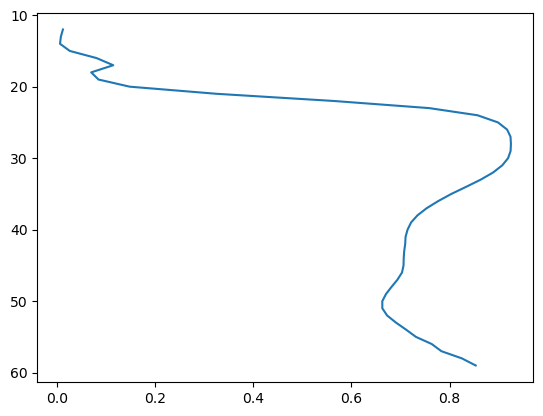

In [25]:
import matplotlib.pyplot as plt
plt.plot(R2[:,1],np.arange(60))
plt.gca().invert_yaxis()

(0.0, 1.0)

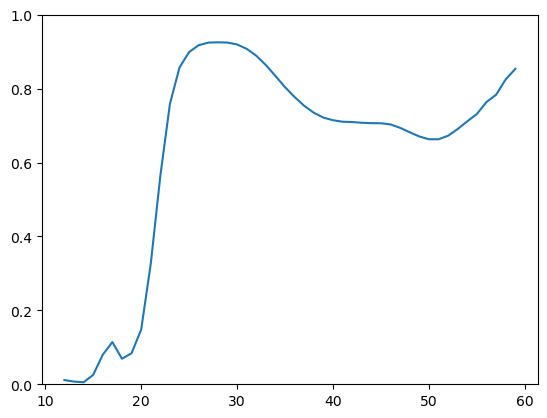

In [28]:
plt.plot(np.arange(60),R2[:,1])
plt.ylim(0,1)

(0.0, 1.0)

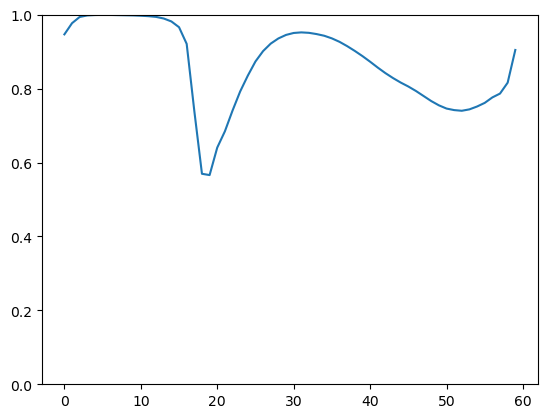

In [26]:
plt.plot(np.arange(60),R2[:,0])
plt.ylim(0,1)

In [27]:
R2[:,0]

array([0.9466978 , 0.9770285 , 0.99382734, 0.99799865, 0.99909216,
       0.9994714 , 0.9993281 , 0.99887717, 0.99846625, 0.9980534 ,
       0.9971655 , 0.99597454, 0.993997  , 0.98964214, 0.98169845,
       0.9661159 , 0.921062  , 0.7394638 , 0.5695126 , 0.5660285 ,
       0.6403861 , 0.6843695 , 0.74047786, 0.79226625, 0.83503765,
       0.87337685, 0.90147734, 0.9217613 , 0.9357034 , 0.9452235 ,
       0.95050424, 0.95207465, 0.950873  , 0.9475209 , 0.94296634,
       0.93585926, 0.9265152 , 0.9148766 , 0.90190625, 0.88793665,
       0.8727932 , 0.8568837 , 0.84192264, 0.8285098 , 0.81639445,
       0.8056849 , 0.79353935, 0.77991784, 0.7662803 , 0.7547418 ,
       0.746002  , 0.74183106, 0.74000907, 0.7438193 , 0.75155765,
       0.761369  , 0.7761432 , 0.78656244, 0.8160264 , 0.9044912 ],
      dtype=float32)